In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
from dateutil.parser import parse
from statsmodels.tsa.stattools import acf, pacf
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv("/Users/gulnihal/Desktop/births2015/Births2015.csv")

from pandas import read_csv
from pandas import DataFrame
from pandas import concat
series = read_csv("/Users/gulnihal/Desktop/births2015/Births2015.csv")



dataframe = DataFrame()
dataframe['month'] = [series["month"][i] for i in range(len(series))]
dataframe['day'] = [series["day_of_year"][i] for i in range(len(series))]
dataframe['wday'] = [series["day_of_week"][i] for i in range(len(series))]
dataframe['births'] = [series["births"][i] for i in range(len(series))]

In [2]:
import glob


Splitting dataset into training and validation part

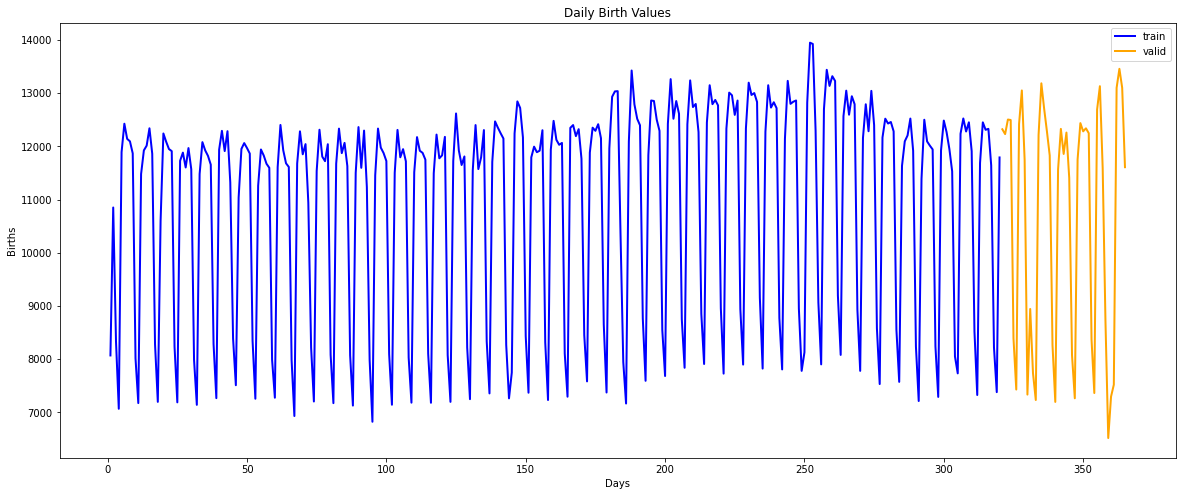

In [3]:
#train_set, test_set= np.split(data, [int(.67 *len(data))])

train_set = data[:320]
valid_set = data[320:]

plt.figure( figsize = (20,8))
plt.plot(  train_set.day_of_year, train_set.births, label = "train", color='blue', linewidth = 2, markersize=5)
plt.plot(  valid_set.day_of_year, valid_set.births, label = "valid", color='orange', linewidth = 2, markersize=5)
plt.title("Daily Birth Values")
plt.ylabel("Births")
plt.xlabel("Days")
plt.legend( loc="best")
plt.show()

 1-) Naive Approach

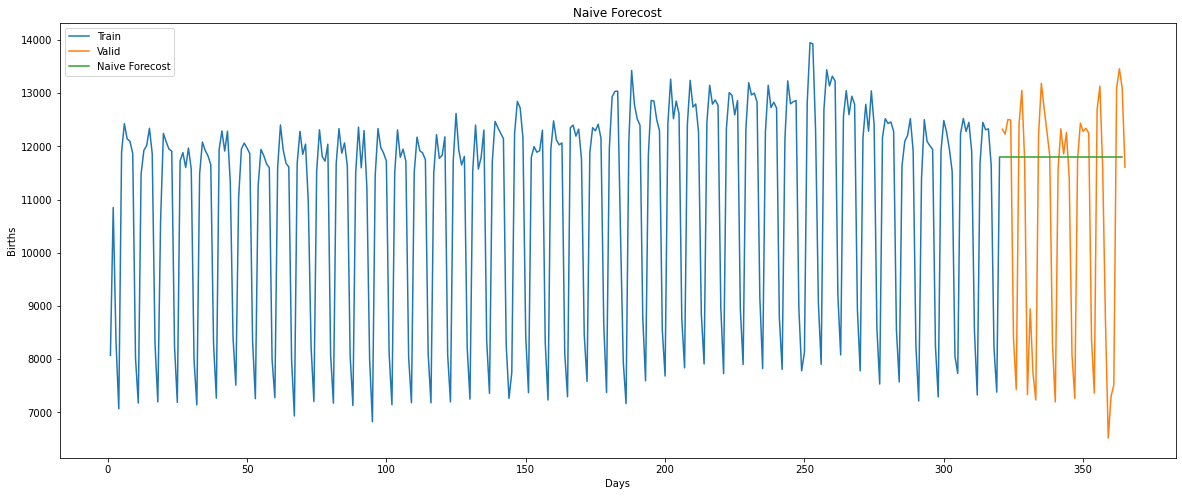

In [4]:
bb = np.asarray(train_set)
y_hat = valid_set.copy()
y_hat["naive"] = bb[len(bb)-1][2]
plt.figure(figsize = (20,8))
plt.plot(train_set.day_of_year, train_set.births, label = "Train")
plt.plot(valid_set.day_of_year, valid_set.births, label = "Valid")
plt.plot(y_hat.index, y_hat["naive"], label = "Naive Forecost")
plt.legend(loc="best")
plt.ylabel("Births")
plt.xlabel("Days")
plt.title("Naive Forecost")
plt.show()


    We can calculate how accurate our prediction are using rmse(Root Mean Square Error).

In [5]:
from sklearn.metrics import mean_squared_error
from math import sqrt


rms = sqrt(mean_squared_error(valid_set.births, y_hat["naive"]))
print(rms)



2531.305561255781


    This method is not suitable for datasets with high variability.

2-) Moving Average 

    In this technique, the average of the passenger counts for last few time periods are taken only.

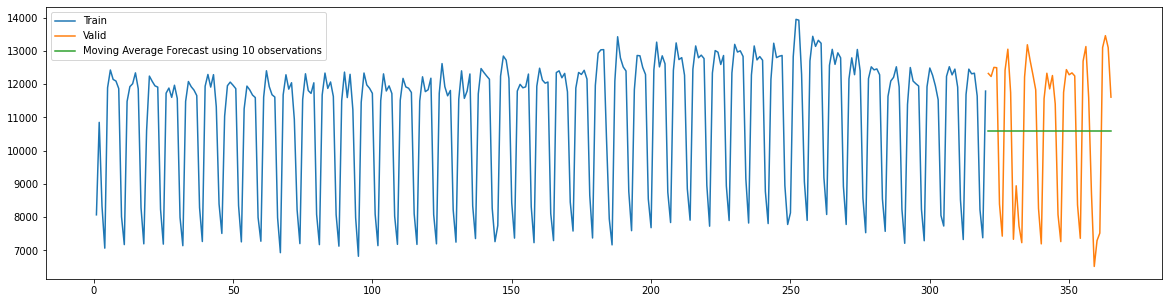

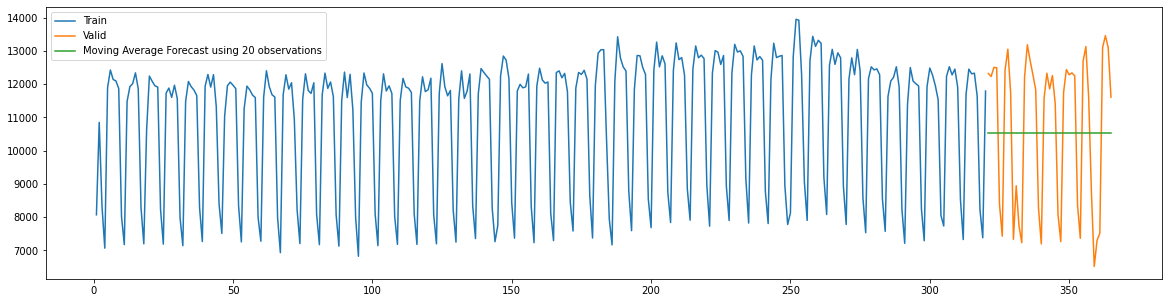

In [6]:
y_hat_avg = valid_set.copy()
y_hat_avg["moving_avg_forecast"] = data["births"].rolling(10).mean().iloc[-1] #average of last 10 observations
plt.figure(figsize = (20,5))
plt.plot(train_set.day_of_year, train_set.births, label = "Train")
plt.plot(valid_set.day_of_year, valid_set.births, label = "Valid")
plt.plot(y_hat_avg.day_of_year, y_hat_avg["moving_avg_forecast"], label = "Moving Average Forecast using 10 observations" )
plt.legend(loc = "best")
plt.show()

y_hat_avg = valid_set.copy()
y_hat_avg["moving_avg_forecast"] = data["births"].rolling(20).mean().iloc[-1] #average of last 20 observations
plt.figure(figsize = (20,5))
plt.plot(train_set.day_of_year, train_set.births, label = "Train")
plt.plot(valid_set.day_of_year, valid_set.births, label = "Valid")
plt.plot(y_hat_avg.day_of_year, y_hat_avg["moving_avg_forecast"], label = "Moving Average Forecast using 20 observations" )
plt.legend(loc = "best")
plt.show()


    Predictions are getting weaker as the number of observations is increased. The accuracy;

In [7]:
from sklearn.metrics import mean_squared_error
from math import sqrt


rms = sqrt(mean_squared_error(valid_set.births, y_hat_avg["moving_avg_forecast"]))
print(rms)

2292.683628475106


3-) Simple Exponential Smoothing 
 
    Larger weights are assigned to more recent observations than to observations from distant past. The weights decrease exponentially.   

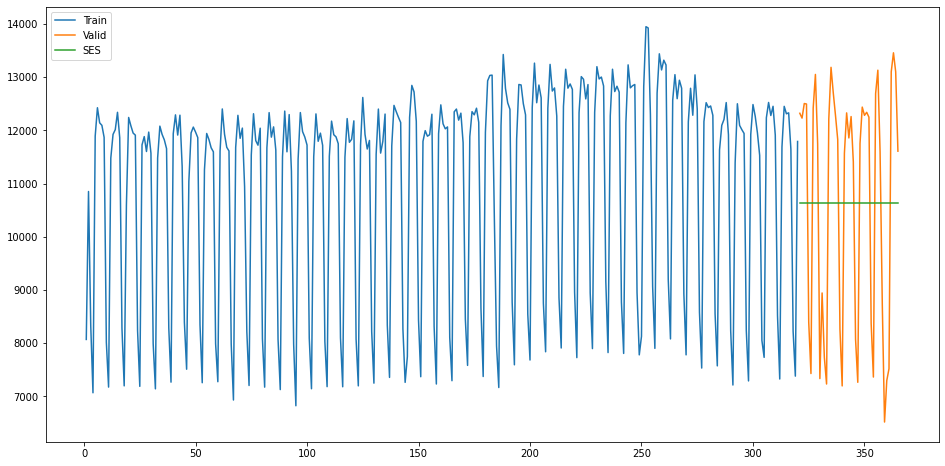

In [8]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = valid_set.copy()

fit2 = SimpleExpSmoothing(np.asarray(train_set["births"])).fit(smoothing_level = 0.7, optimized = False)
y_hat_avg["SES"] = fit2.forecast(len(valid_set))
plt.figure(figsize=(16,8))
plt.plot(train_set.day_of_year, train_set.births, label = "Train")
plt.plot(valid_set.day_of_year, valid_set.births, label = "Valid")
plt.plot(y_hat_avg.day_of_year, y_hat_avg["SES"], label = "SES")
plt.legend( loc= "best")
plt.show()



In [9]:
rms = sqrt(mean_squared_error(valid_set.births, y_hat_avg["SES"]))
print(rms)

2287.7828473312225


4-) Holt's Linear Trend Model

    allows forecasting of data with a trend.

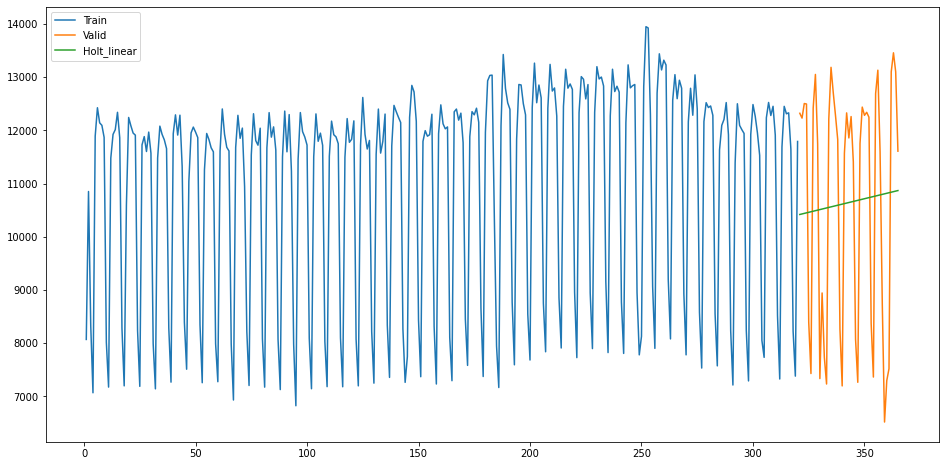

In [10]:
import statsmodels.api as sm
result = sm.tsa.stattools.adfuller(data["births"])

y_hat_avg = valid_set.copy()
fit1 = Holt(np.asarray(train_set["births"])).fit( smoothing_level = 0.7, smoothing_trend = 0.21)
y_hat_avg["Holt_linear"] = fit1.forecast(len(valid_set))
plt.figure(figsize=(16,8))
plt.plot(train_set.day_of_year, train_set.births, label = "Train")
plt.plot(valid_set.day_of_year, valid_set.births, label = "Valid")
plt.plot(y_hat_avg.day_of_year, y_hat_avg["Holt_linear"], label = "Holt_linear")
plt.legend( loc= "best")
plt.show()


In [11]:
rms = sqrt(mean_squared_error(valid_set["births"], y_hat_avg.Holt_linear))
print(rms)

2294.484753216261


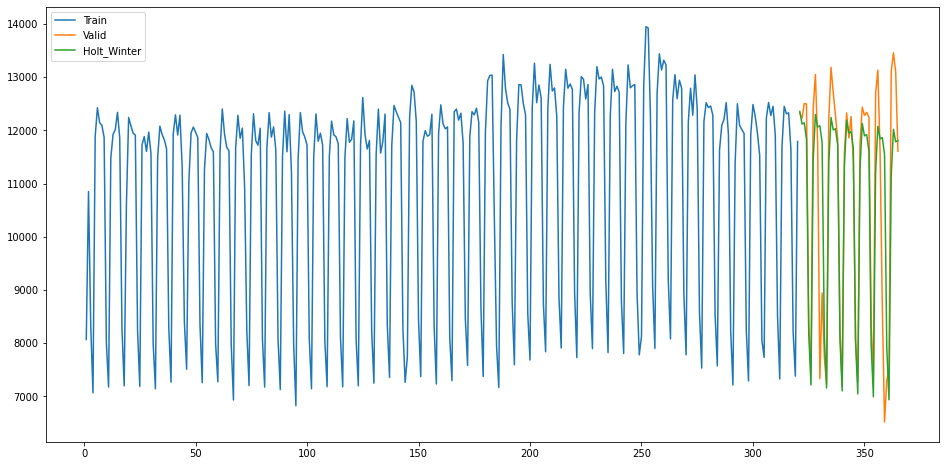

In [12]:
y_hat_avg = valid_set.copy()
fit1 = ExponentialSmoothing(np.asarray(train_set["births"]),seasonal_periods = 7, trend="add", seasonal = "add").fit()
y_hat_avg["Holt_Winter"] = fit1.forecast(len(valid_set))

plt.figure(figsize=(16,8))
plt.plot(train_set.day_of_year, train_set.births, label = "Train")
plt.plot(valid_set.day_of_year, valid_set.births, label = "Valid")
plt.plot(y_hat_avg.day_of_year, y_hat_avg["Holt_Winter"], label = "Holt_Winter")
plt.legend( loc= "best")
plt.show()


In [13]:
rms = sqrt(mean_squared_error(valid_set["births"], y_hat_avg.Holt_Winter))
print(rms)

1364.739683636527


    RMS value has reduced a lot from this method

# ARIMA (Auto Regression Integrated Moving Average)

    The model considers both the trend and seasonality part. 
    (p,d,q); 
        p : the order of the autoregressive model (# of time lags)
        d : the degree of differencing (# of times the data have had past values substracted)
        q : the order of moving average model
        
     The ARIMA forecasting for a stationary time deries is nothing but a linear (like a linear regression) equation.

Stationary Time Series : The mean, variance and covariance shouldn't be a function of time. We make the series stationary to make variables independent. For doing so, we need to remove the trend and seasonality from the data. 

## Stationarity Check 

We use DICKEY fULLER test, which determines how strongly a times series defined by a trend.

The null hypothesis (0H) : not stationary
The alternate hypothesis (1H) : stationary

If the Test Statistic is less than the Critical Value, we can reject the null hypothesis and say that the series is stationary.



Results of Dickey-Fuller Test:
Test Statistics                 -1.601399
p-value                          0.482890
#lags Used                      14.000000
Number of Observations Used    350.000000
Critical Value(1%)              -3.449173
Critical Value(5%)              -2.869833
Critical Value(10%)             -2.571188
dtype: float64


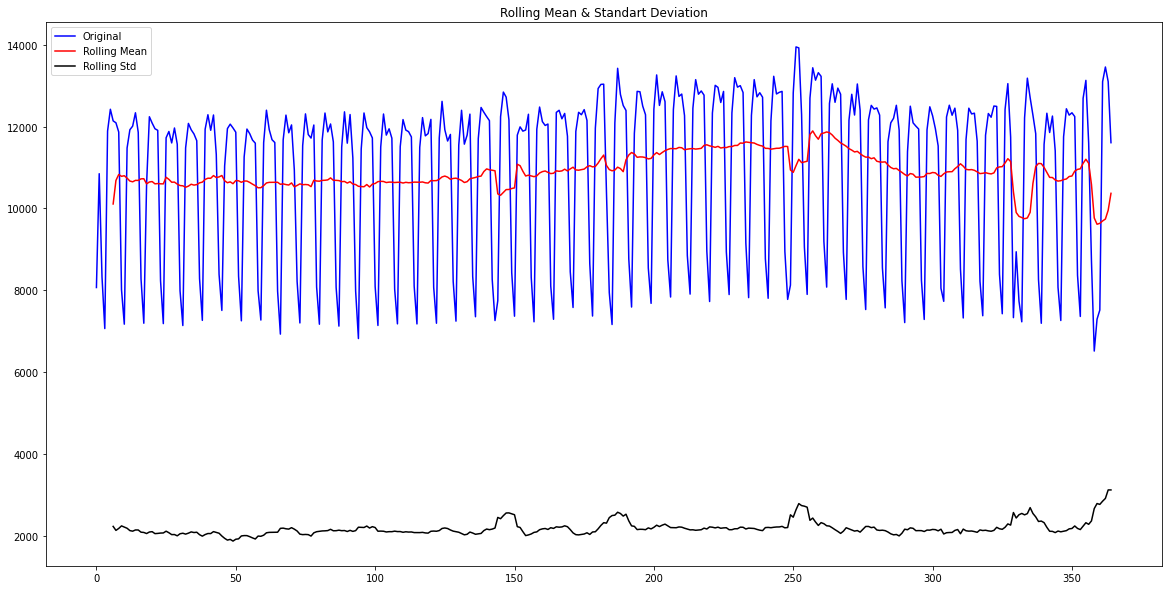

In [14]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics

    rolmean = timeseries.rolling(7).mean()
    rolstd = timeseries.rolling(7).std()
    
    #Plot rolling statistics
    
    orig = plt.plot( timeseries, color="blue", label = "Original")
    mean = plt.plot( rolmean, color="red", label = "Rolling Mean")
    std = plt.plot( rolstd, color="black", label = "Rolling Std")
    plt.legend(loc="best")
    plt.title("Rolling Mean & Standart Deviation")
    
    #Perform Dickey-Fuller Test 
    
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index=["Test Statistics","p-value","#lags Used","Number of Observations Used"])
    
    for key,value in dftest[4].items():
        dfoutput["Critical Value(%s)"%key] = value
    
    print(dfoutput)
    
from matplotlib.pylab import rcParams
rcParams["figure.figsize"] = 20,10
test_stationarity(data["births"])
    
    


    The statistics shows the time series is not stationary as p-value > 0.005.
    We should remove the trend and seasonality from data to make the data more stationary.

REMOVING TREND : We should apply transmormation which penalizes higher values more than ones, like log transformation. 

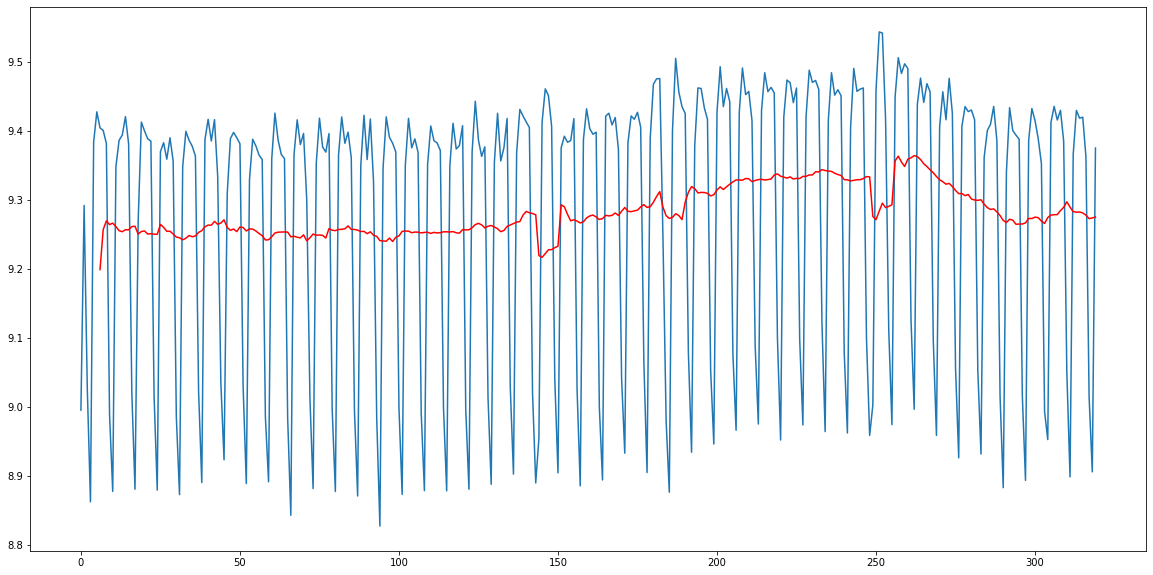

In [15]:

train_log = np.log(train_set["births"])
valid_log = np.log(valid_set["births"])

moving_avg = train_log.rolling(window=7).mean()

plt.plot(train_log)
plt.plot(moving_avg, color="red")
plt.show()



Results of Dickey-Fuller Test:
Test Statistics                 -5.580020
p-value                          0.000001
#lags Used                      14.000000
Number of Observations Used    299.000000
Critical Value(1%)              -3.452411
Critical Value(5%)              -2.871255
Critical Value(10%)             -2.571947
dtype: float64


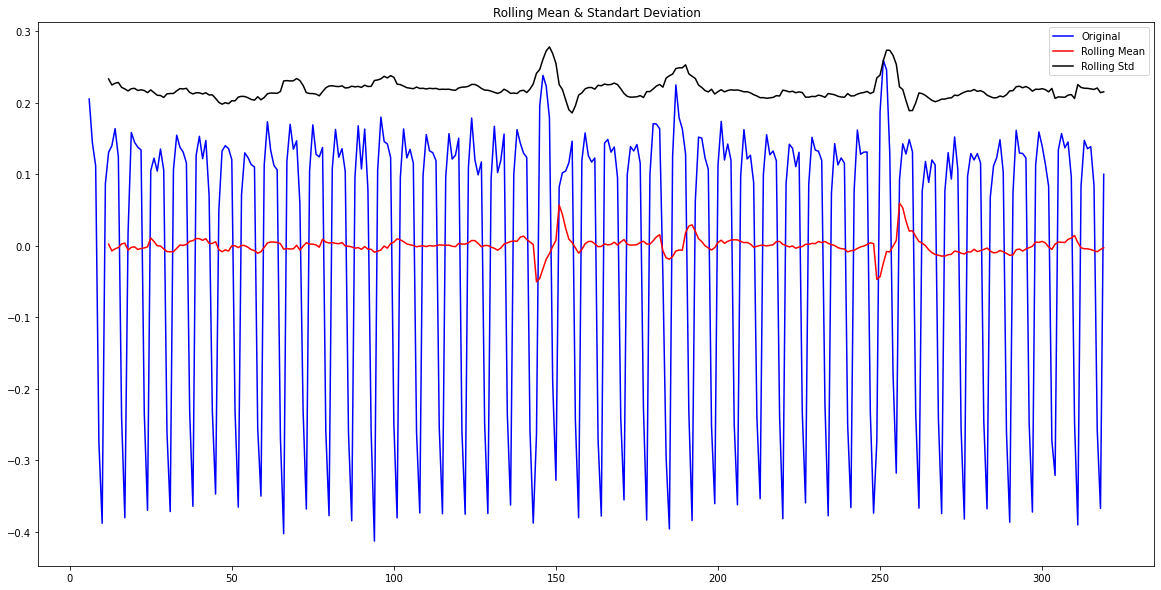

In [16]:
train_log_moving_avg_diff = train_log - moving_avg 
train_log_moving_avg_diff.dropna(inplace= True)
test_stationarity(train_log_moving_avg_diff)

    Test Statistics is very small as compared to the Critical Value. So, the trend is almost removed.
    Now, stabilize the mean of the time teries which is also a requirement for a time series.

Results of Dickey-Fuller Test:
Test Statistics               -1.017034e+01
p-value                        7.117312e-18
#lags Used                     1.200000e+01
Number of Observations Used    3.060000e+02
Critical Value(1%)            -3.451902e+00
Critical Value(5%)            -2.871032e+00
Critical Value(10%)           -2.571827e+00
dtype: float64


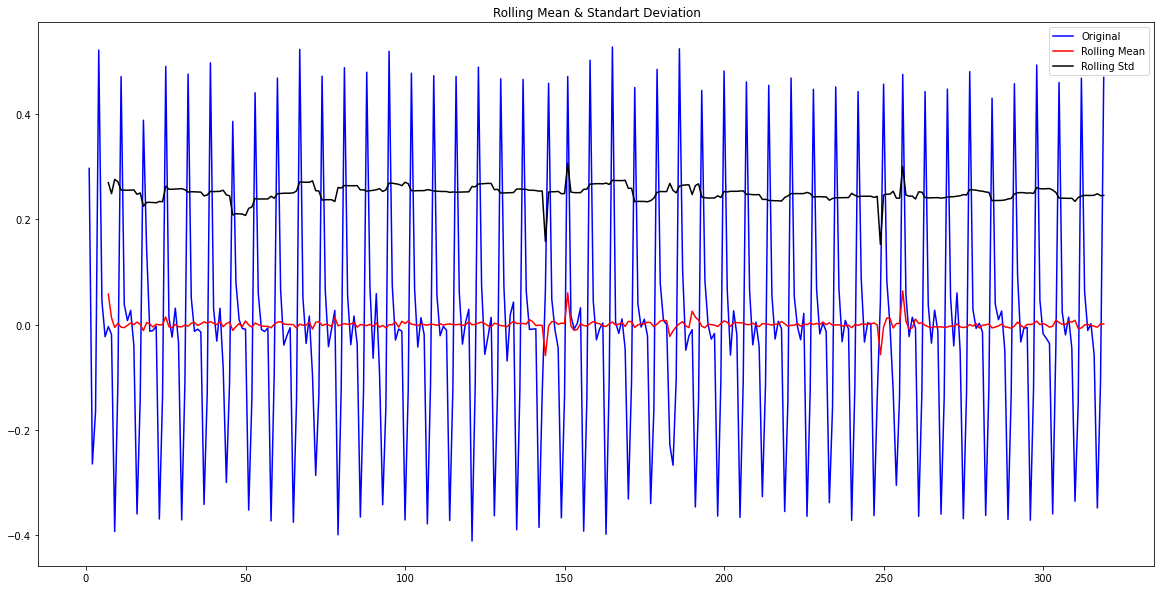

In [17]:
train_log_diff = train_log - train_log.shift(1)
test_stationarity(train_log_diff.dropna())

REMOVING SEASONALITY : 

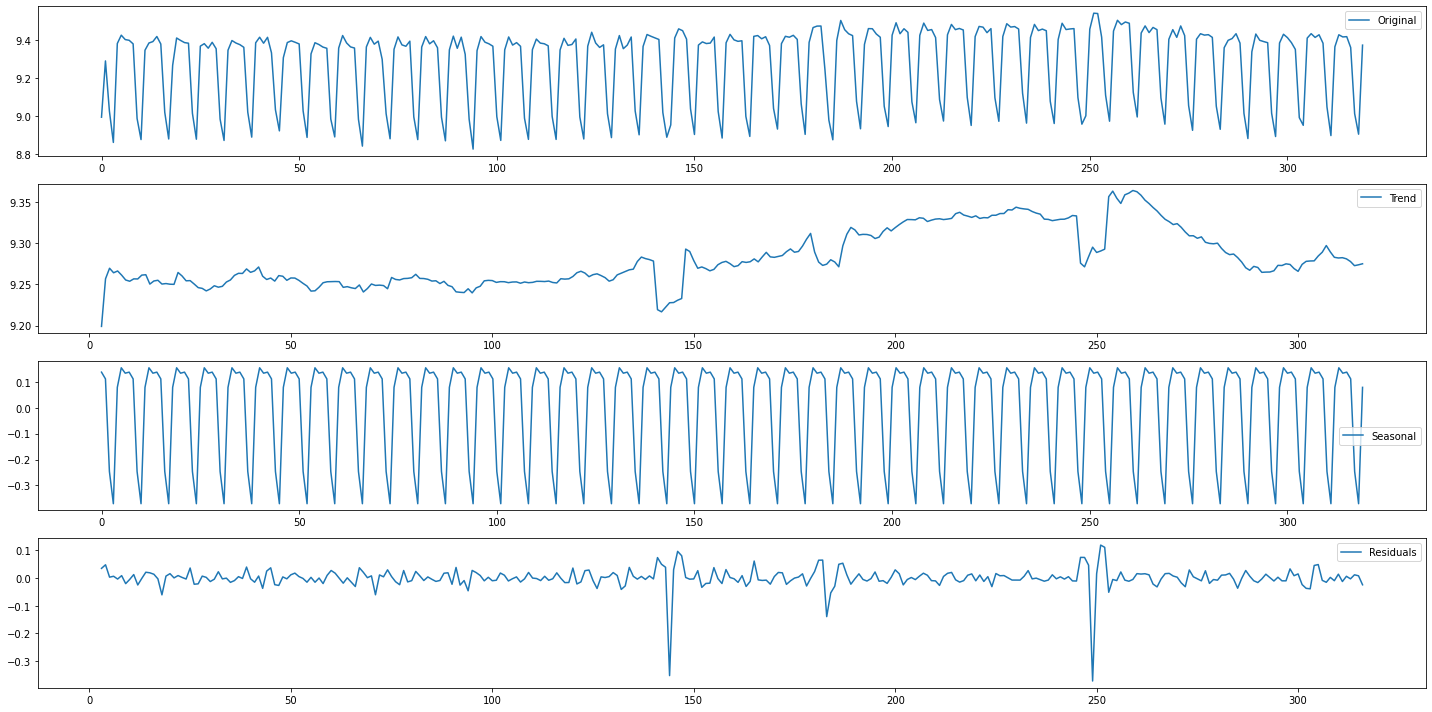

In [18]:

decomposition = seasonal_decompose(train_log.values, period=7)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(train_log,label="Original")
plt.legend(loc="best")

plt.subplot(412)
plt.plot(trend,label="Trend")
plt.legend(loc="best")

plt.subplot(413)
plt.plot(seasonal,label="Seasonal")
plt.legend(loc="best")

plt.subplot(414)
plt.plot(residual,label="Residuals")
plt.legend(loc="best")

plt.tight_layout()
plt.show()


    Let's check the stationarity of residuals.

Results of Dickey-Fuller Test:
Test Statistics               -8.672832e+00
p-value                        4.497927e-14
#lags Used                     1.600000e+01
Number of Observations Used    2.970000e+02
Critical Value(1%)            -3.452561e+00
Critical Value(5%)            -2.871321e+00
Critical Value(10%)           -2.571982e+00
dtype: float64


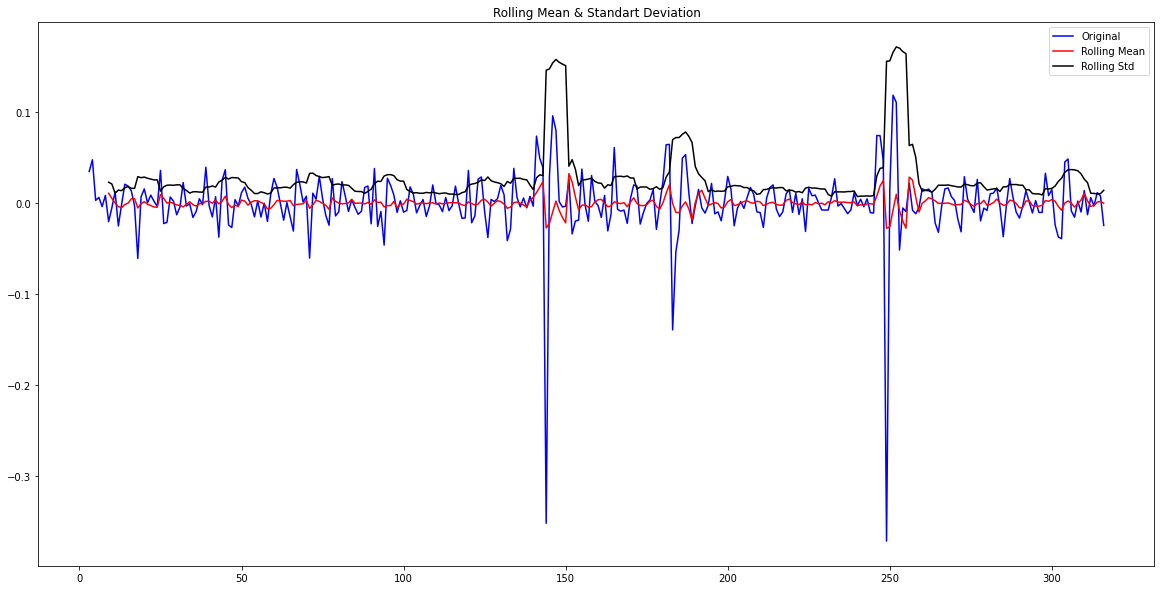

In [19]:
train_log_decompose = pd.DataFrame(residual)
train_log_decompose.dropna(inplace=True)
test_stationarity(train_log_decompose)

    So, the residuals are stationary.

Firts of all, we should find the optimized vales for the p,d,q parameters to fit the ARIMA model on our time series.
We can utilize ACF and PACF graph.

As we know from Feature Engineering part;

- p is the lag values where the PACF chart crosses the upper confidence interval for the first time, namely p=7.

- q is the lag values where the ACF chart crosses the upper confidence interval for the first time, namely q=7.


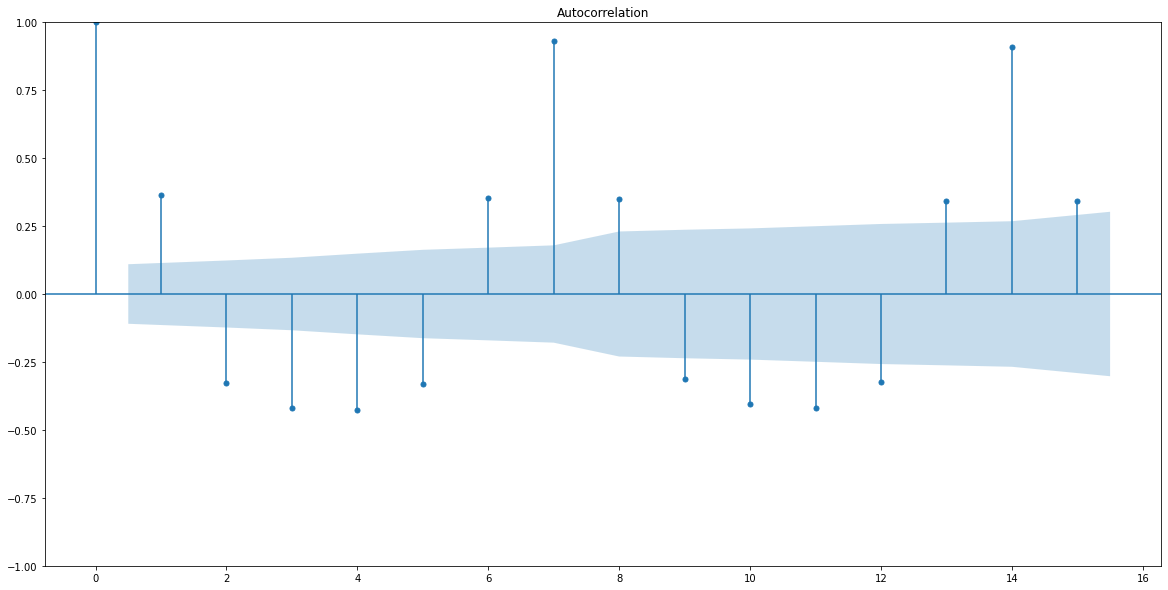

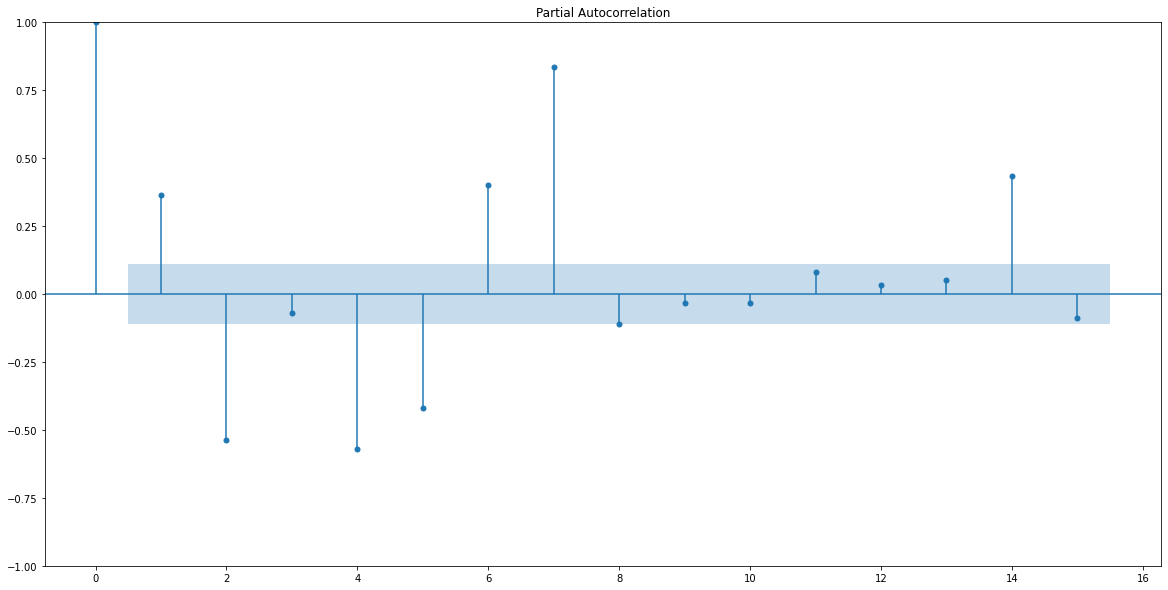

In [20]:
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import pyplot

plot_acf(train_log, lags=15)
pyplot.show()



from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train_log, lags=15)
pyplot.show()

In [21]:
result = adfuller(train_log.dropna())
print("p-value:",result[1])
result = adfuller(train_log.diff().dropna())
print("p-value:",result[1])
result = adfuller(train_log.diff().dropna())
print("p-value:",result[1])

p-value: 0.4575900362668659
p-value: 7.117311916937504e-18
p-value: 7.117311916937504e-18


    d=1 since after the first order differencing, the p-value drops beyond the acceptable treshold 

In [22]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_log_diff.dropna(), order=(7,1,7))
results = model.fit()

prediction = results.forecast(45, alpha=0.05)

results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 births   No. Observations:                  319
Model:                 ARIMA(7, 1, 7)   Log Likelihood                 447.677
Date:                Thu, 11 Aug 2022   AIC                           -865.354
Time:                        17:21:28   BIC                           -808.923
Sample:                             0   HQIC                          -842.815
                                - 319                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4451      0.057    -25.469      0.000      -1.556      -1.334
ar.L2         -1.4450      0.057    -25.450      0.000      -1.556      -1.334
ar.L3         -1.4407      0.064    -22.680      0.000      -1.565      -1.316
ar.L4         -1.4389      0.059    -24.370      0.000      -1.555      -1.323
ar.L5         -1.4435      0.057    -25.303      0.000      -1.555      -1.332
ar.L6         -1.4376      0.054    -26.549      0.000      -1.544      -1.332
ar.L7         -0.4478      0.052     -8.568      0.000      -0.550      -0.345
ma.L1         -0.0250      0.071     -0.352      0.725      -0.164       0.114
ma.L2         -0.2670      0.037     -7.268      0.000      -0.339      -0.195
ma.L3         -0.1499      0.072     -2.093      0.036      -0.290      -0.010
ma.L4         -0.0471      0.071     -0.667      0.505      -0.186       0.091
ma.L5          0.0913      0.054      1.682      0.093      -0.015       0.198
ma.L6          0.1206      0.069      1.737      0.082      -0.016       0.257
ma.L7         -0.6590      0.046    -14.224      0.000      -0.750      -0.568
sigma2         0.0033      0.000     26.109      0.000       0.003       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              3704.21
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                            -2.03
Prob(H) (two-sided):                  0.16   Kurtosis:                        19.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We set dynamic=False so that the in-sample lagged values are used for prediction .

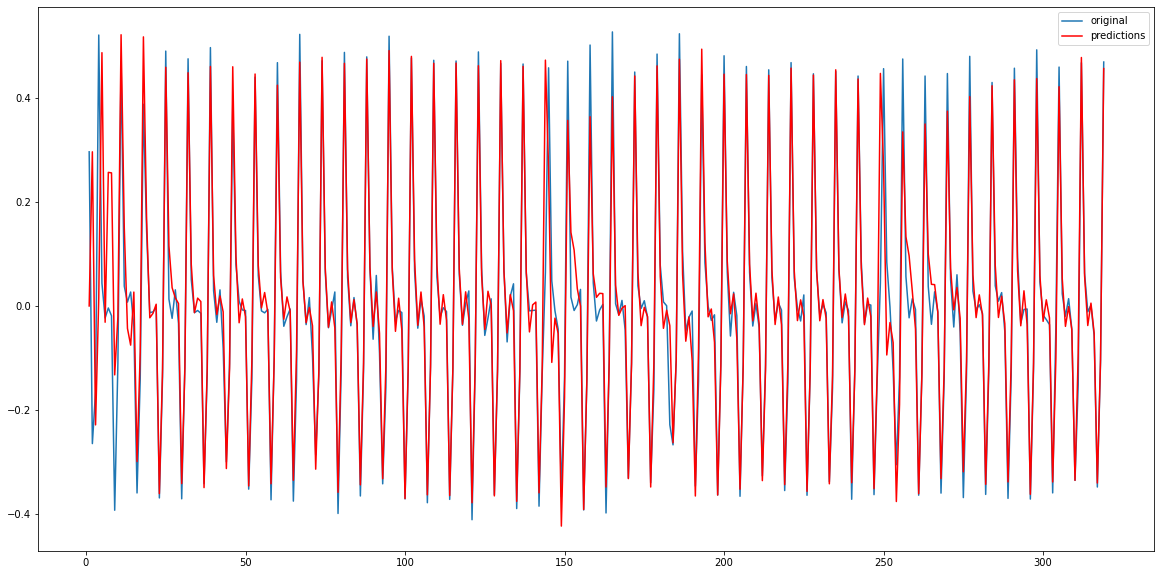

In [23]:

plt.plot(train_log_diff.dropna(), label="original")
plt.plot(results.fittedvalues,color="red", label="predictions")


plt.legend(loc="best")

plt.show()



At this point, I couldn't define a function which can be used to change the scale of the model to the original scale.

# Auto ARIMA

In [24]:
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
from datetime import datetime
import pmdarima as pm

Let's set the index as days of the year.

In [25]:
data = data.filter(["births","day_of_year"])
data.set_index(data["day_of_year"], inplace = True)
data = data.filter(["births"])

<AxesSubplot:xlabel='day_of_year'>

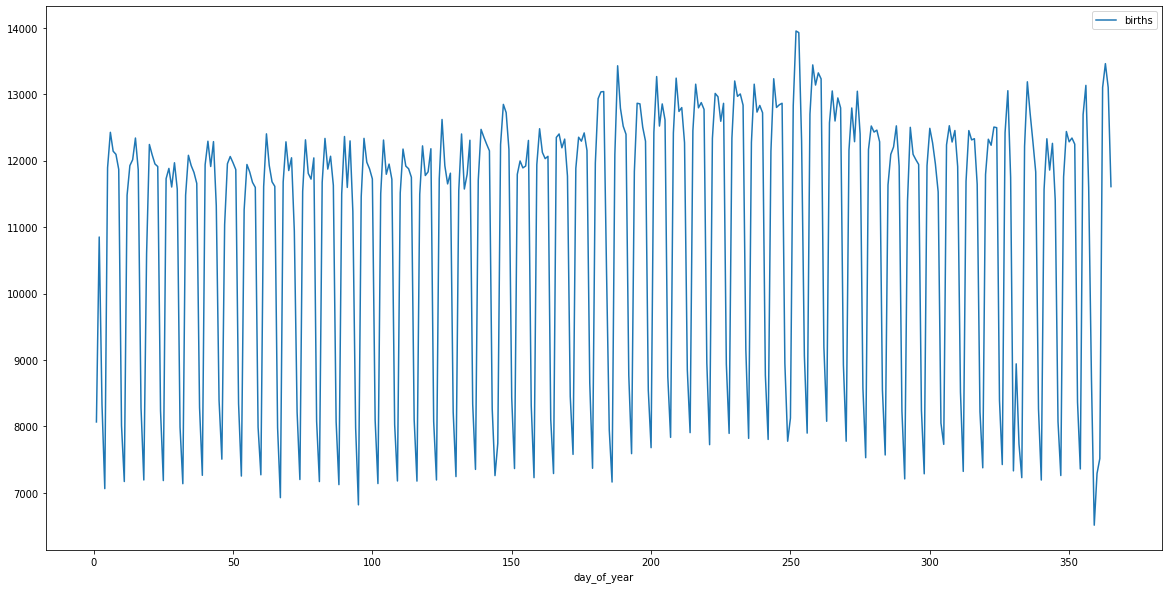

In [26]:
data.plot()

Test for Stationarity

In [27]:
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(data["births"])

(0.01, False)

    non-stationary 

In [28]:
TEST_SIZE = 30
train, test = data.iloc[:-TEST_SIZE], data.iloc[-TEST_SIZE:]
x_train, x_test = np.array(range(train.shape[0])), np.array(range(train.shape[0], data.shape[0]))
train.shape, x_train.shape, test.shape, x_test.shape

((335, 1), (335,), (30, 1), (30,))

<Figure size 1080x360 with 0 Axes>

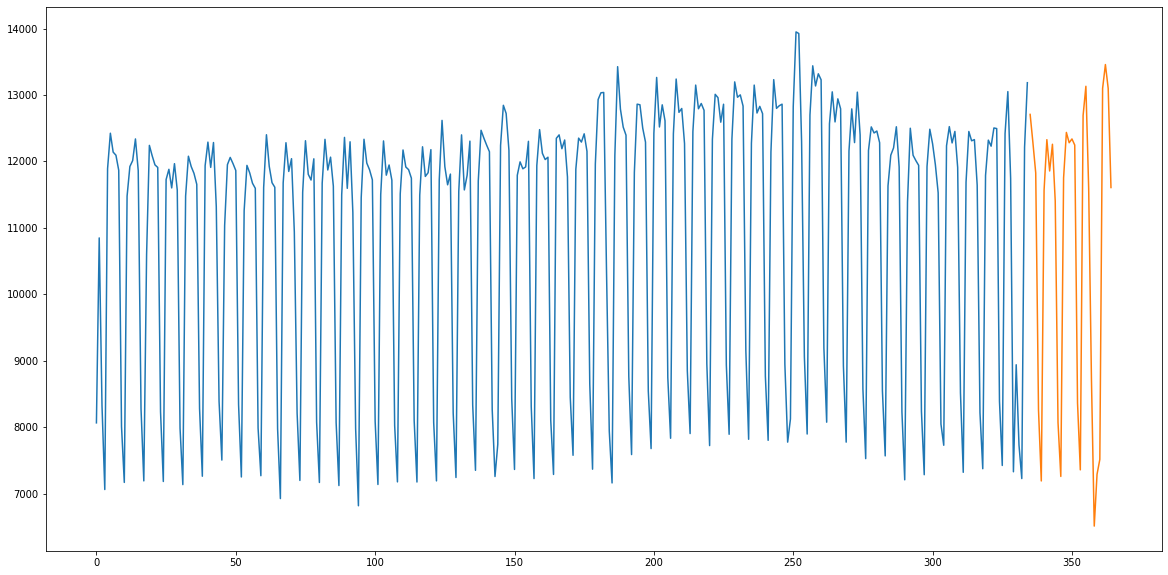

In [29]:
plt.figure(figsize=(15, 5))
plt.subplots(1, 1)
plt.plot(x_train, train.values)
plt.plot(x_test, test.values)

In [30]:
model = auto_arima(train, start_p=1, start_q=1,
                      test='adf', #use adftest to find optimal "d"
                      max_p=8, max_q=8,
                      m=1, #freq of series (if m==1, seasonal is set to False automatically)            
                      d=1,          
                      seasonal=False, #No seasonality for standard ARIMA   
                      start_P=0, 
                      D=None,  #Let model determine "d"
                      trace=True,  #logs
                      error_action='ignore',  #shows errors ('ignore' silences these) 
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6066.809, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6113.024, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6112.137, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6092.384, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6111.041, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6015.799, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6015.338, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=6017.263, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6011.821, Time=0.16 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=5757.188, Time=0.37 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=5955.601, Time=0.07 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=5555.650, Time=0.46 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=5674.421, Time=0.13 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=5397.989, Time=0.55 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept

In [32]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  335
Model:               SARIMAX(7, 1, 3)   Log Likelihood               -2684.951
Date:                Thu, 11 Aug 2022   AIC                           5391.902
Time:                        17:23:22   BIC                           5433.824
Sample:                             0   HQIC                          5408.617
                                - 335                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1532      0.171     -0.898      0.369      -0.488       0.181
ar.L2         -0.2605      0.174     -1.494      0.135      -0.602       0.081
ar.L3         -0.2080      0.152     -1.367      0.172      -0.506       0.090
ar.L4         -0.1872      0.175     -1.072      0.284      -0.530       0.155
ar.L5         -0.2535      0.156     -1.622      0.105      -0.560       0.053
ar.L6         -0.1416      0.166     -0.852      0.394      -0.468       0.184
ar.L7          0.6534      0.157      4.159      0.000       0.345       0.961
ma.L1         -0.4428      0.173     -2.553      0.011      -0.783      -0.103
ma.L2         -0.2591      0.119     -2.181      0.029      -0.492      -0.026
ma.L3         -0.1326      0.099     -1.346      0.178      -0.326       0.061
sigma2      4.052e+05   1.57e+04     25.868      0.000    3.75e+05    4.36e+05
===================================================================================
Ljung-Box (L1) (Q):                   2.95   Jarque-Bera (JB):              5688.24
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                             0.47
Prob(H) (two-sided):                  0.26   Kurtosis:                        23.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
# Forecast

prediction, confint = model.predict(n_periods=TEST_SIZE, return_conf_int=True)

prediction

array([11804.07161809,  8147.74475786,  9342.33639281,  8236.17149502,
        7832.06878659, 12086.87413236, 13303.42771235, 11612.58270811,
        8467.62869735,  9380.20866451,  8439.74572991,  8141.68052373,
       11867.35316533, 13230.40257527, 11398.43717121,  8659.21614406,
        9380.35108845,  8592.81662621,  8370.31388775, 11677.74881274,
       13102.09167563, 11224.19682455,  8802.34455175,  9386.44917158,
        8730.53645717,  8559.22437588, 11523.32439157, 12951.32433144,
       11086.79541287,  8917.18138965])

In [34]:
from sklearn.metrics import r2_score
test["predicted_births"] = prediction
r2_score(test["births"], test["predicted_births"])

0.37841876022029164

In [35]:
cf= pd.DataFrame(confint)

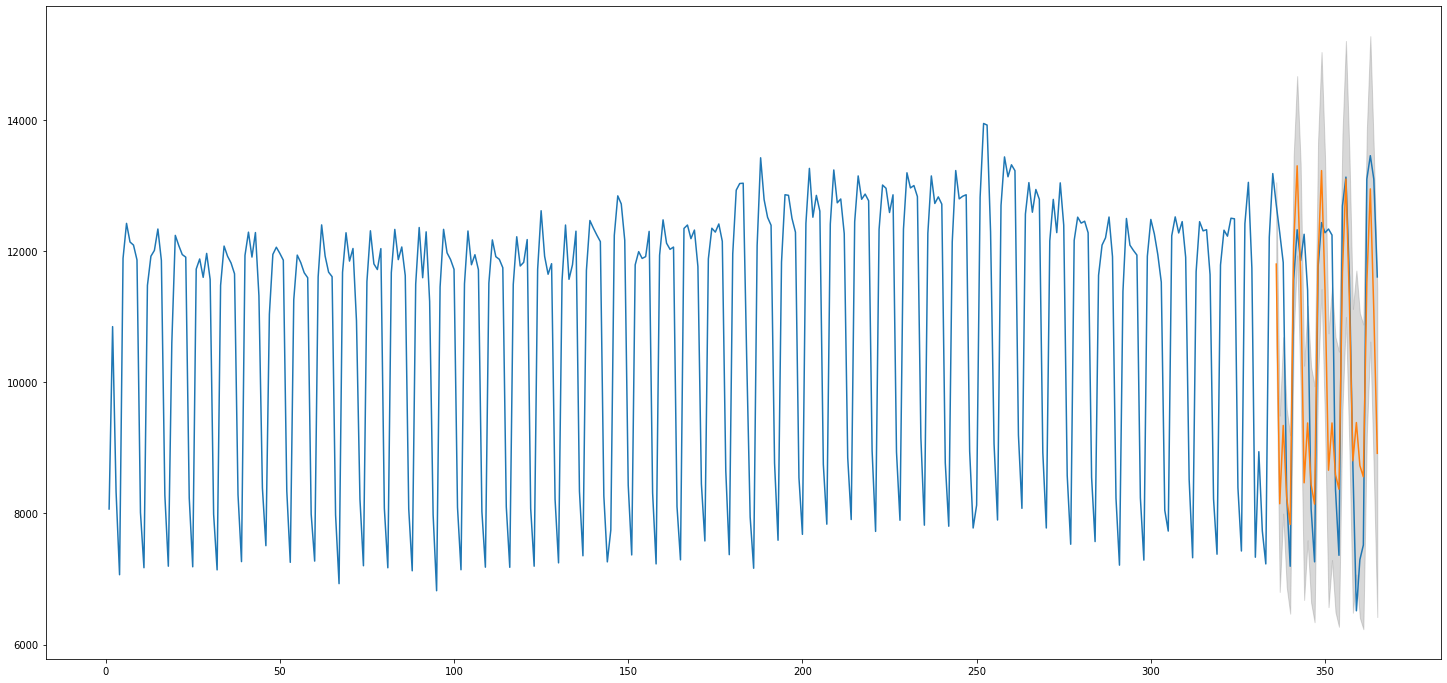

In [36]:
prediction_series = pd.Series(prediction,index=test.index)
fig, ax = plt.subplots(1, 1, figsize=(25, 12))
ax.plot(data.births)
ax.plot(prediction_series)
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)

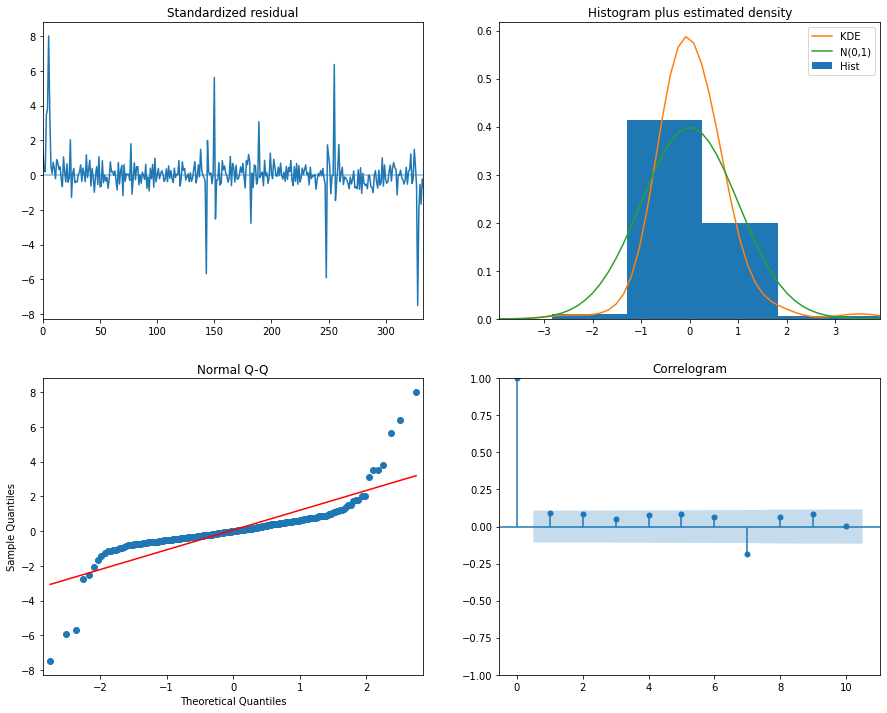

In [37]:
model.plot_diagnostics(figsize=(15,12))
plt.show()

SMAPE( Symmetric Mean Absolute Error)

In [38]:
def calcsmape(actual, forecast):
    return 1/len(actual) * np.sum(2 * np.abs(forecast-actual) / (np.abs(actual) + np.abs(forecast)))


smape=calcsmape(test.births,prediction)
smape

0.1323743323997262

In [39]:
#Defining MAPE function
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

MAPE(test.births,prediction_series)

12.644789751658925

    %88 Accuracy

# SARIMA

In [40]:
import statsmodels.api as sm

In [41]:
df = pd.read_csv("/Users/gulnihal/Desktop/births2015/Births2015.csv")

In [42]:
#string to date format
df['day'] = pd.to_datetime(df['date'],infer_datetime_format=True)
df = df.set_index(['day'])
df = df.filter(["births"])
df.head(5)



,births
day,
2015-01-01,8068
2015-01-02,10850
2015-01-03,8328
2015-01-04,7065
2015-01-05,11892


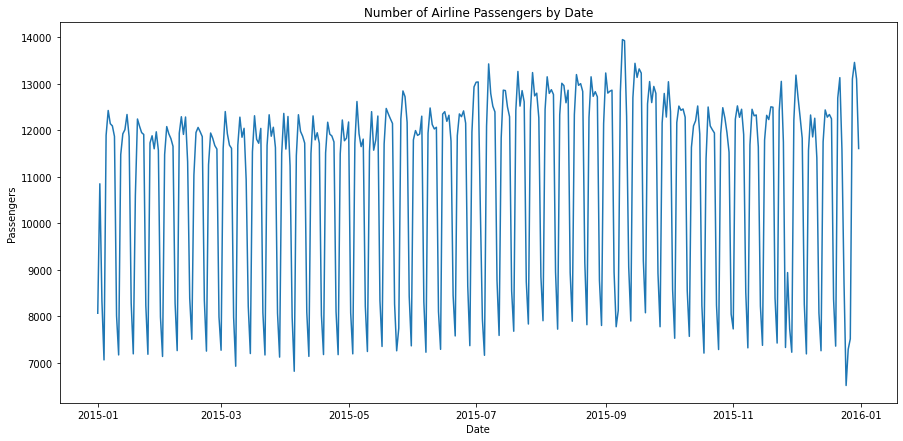

In [43]:

plt.figure(figsize=(15,7))
plt.title("Number of Airline Passengers by Date")
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.plot(df)
plt.show()

In [44]:
model=sm.tsa.statespace.SARIMAX(df['births'], order=(7, 1, 2),seasonal_order=(1,1,1,10))
results=model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.37555D+00    |proj g|=  4.09700D+00


 This problem is unconstrained.



At iterate    5    f=  8.10348D+00    |proj g|=  2.43209D-01

At iterate   10    f=  8.07109D+00    |proj g|=  2.86378D-01

At iterate   15    f=  8.01697D+00    |proj g|=  3.46961D-01

At iterate   20    f=  7.97582D+00    |proj g|=  5.25334D-02

At iterate   25    f=  7.96655D+00    |proj g|=  6.47820D-03

At iterate   30    f=  7.96556D+00    |proj g|=  2.08396D-02

At iterate   35    f=  7.96508D+00    |proj g|=  8.39983D-03

At iterate   40    f=  7.96486D+00    |proj g|=  4.63601D-03

At iterate   45    f=  7.96455D+00    |proj g|=  8.69906D-03

At iterate   50    f=  7.96441D+00    |proj g|=  1.00401D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

<AxesSubplot:xlabel='day'>

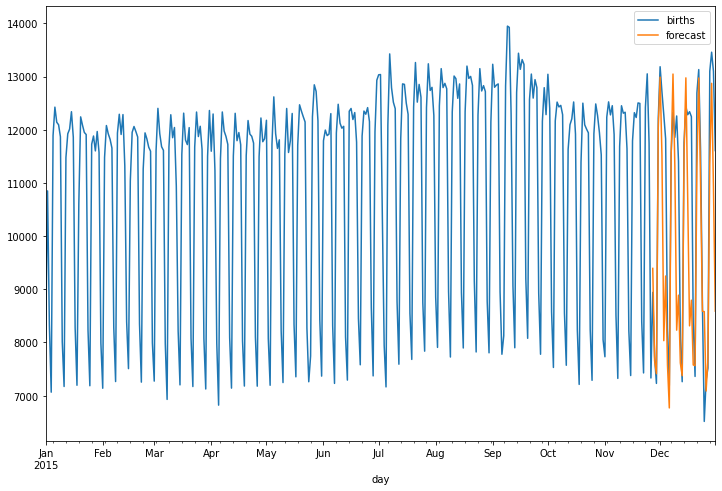

In [45]:
df['forecast']=results.predict(start=330,end=365,dynamic=True)
df[['births','forecast']].plot(figsize=(12,8))

In [46]:
MAPE(df["births"][330:365],df['forecast'].dropna())

10.649944926429848

    %90 Accuracy

# SARIMAX

In [47]:
series = read_csv("/Users/gulnihal/Desktop/births2015/Births2015.csv", header=0, index_col=0)

#string to date format
series['day'] = pd.to_datetime(series['date'],infer_datetime_format=True)
series = series.set_index(['day'])
series = series.filter(["births"])
series.head(5)




,births
day,
2015-01-01,8068
2015-01-02,10850
2015-01-03,8328
2015-01-04,7065
2015-01-05,11892


# FEATURE IMPORTANCE

 LAG OBSERVATION 

In [48]:
# reframe as supervised learning
dataframe = DataFrame()
for i in range(7,0,-1):
	dataframe['t-'+str(i)] = series.shift(i).values[:,0]
dataframe['t'] = series.values[:,0]
print(dataframe.head(8))
dataframe = dataframe[8:]

dataframe

      t-7      t-6      t-5      t-4      t-3      t-2      t-1      t
0     NaN      NaN      NaN      NaN      NaN      NaN      NaN   8068
1     NaN      NaN      NaN      NaN      NaN      NaN   8068.0  10850
2     NaN      NaN      NaN      NaN      NaN   8068.0  10850.0   8328
3     NaN      NaN      NaN      NaN   8068.0  10850.0   8328.0   7065
4     NaN      NaN      NaN   8068.0  10850.0   8328.0   7065.0  11892
5     NaN      NaN   8068.0  10850.0   8328.0   7065.0  11892.0  12425
6     NaN   8068.0  10850.0   8328.0   7065.0  11892.0  12425.0  12141
7  8068.0  10850.0   8328.0   7065.0  11892.0  12425.0  12141.0  12094


,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
8,10850.0,8328.0,7065.0,11892.0,12425.0,12141.0,12094.0,11868
9,8328.0,7065.0,11892.0,12425.0,12141.0,12094.0,11868.0,8014
10,7065.0,11892.0,12425.0,12141.0,12094.0,11868.0,8014.0,7172
11,11892.0,12425.0,12141.0,12094.0,11868.0,8014.0,7172.0,11479
12,12425.0,12141.0,12094.0,11868.0,8014.0,7172.0,11479.0,11924
...,...,...,...,...,...,...,...,...
360,7361.0,12692.0,13131.0,11595.0,8714.0,6515.0,7294.0,7518
361,12692.0,13131.0,11595.0,8714.0,6515.0,7294.0,7518.0,13100
362,13131.0,11595.0,8714.0,6515.0,7294.0,7518.0,13100.0,13458
363,11595.0,8714.0,6515.0,7294.0,7518.0,13100.0,13458.0,13100


Feature Importance of Lag Variables

In [49]:
from sklearn.ensemble import RandomForestRegressor

[0.85640085 0.01259147 0.03403499 0.01543698 0.02050958 0.0232893
 0.03773683]


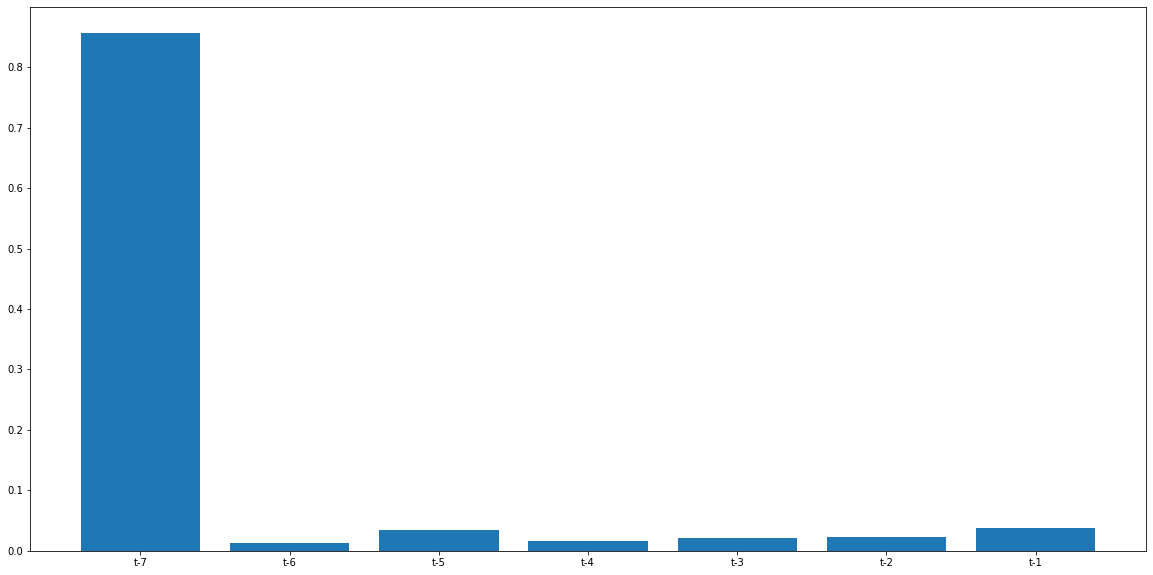

In [50]:
array = dataframe.values
# split into input and output
X = array[:,0:-1]
y = array[:,-1]
# fit random forest model
model = RandomForestRegressor(n_estimators=500, random_state=1)
model.fit(X, y)
# show importance scores
print(model.feature_importances_)
# plot importance scores
names = dataframe.columns.values[0:-1]
ticks = [i for i in range(len(names))]
pyplot.bar(ticks, model.feature_importances_)
pyplot.xticks(ticks, names)
pyplot.show()

The plot shows the high relative importance of the observation at t-7.

Feature Selection of Lag Variables

    Recursive Feature Selection (RFE) works by creating predictive models, weighting features, and pruning those with the smallest weights, then repeating the process until a desired number of features are left.

Selected Features:
t-7
t-5


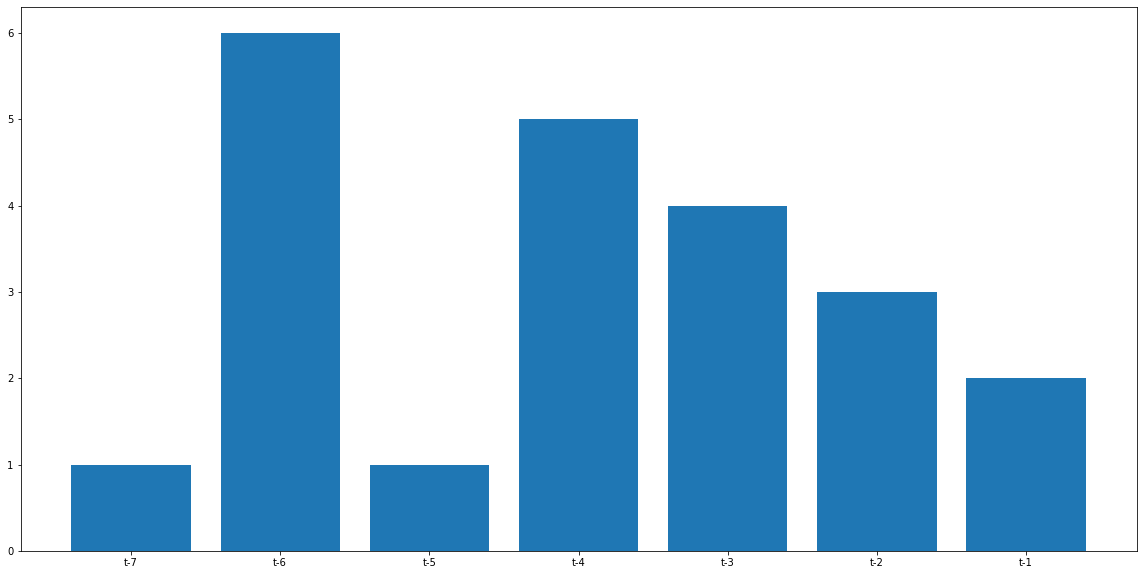

In [51]:
from sklearn.feature_selection import RFE
# perform feature selection
rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=1), n_features_to_select=2)
fit = rfe.fit(X, y)
# report selected features
print('Selected Features:')
names = dataframe.columns.values[0:-1]
for i in range(len(fit.support_)):
	if fit.support_[i]:
		print(names[i])
# plot feature rank
names = dataframe.columns.values[0:-1]
ticks = [i for i in range(len(names))]
pyplot.bar(ticks, fit.ranking_)
pyplot.xticks(ticks, names)
pyplot.show()

In [52]:
series["lag7"] = series["births"].shift(7)
series["lag5"] = series["births"].shift(5)

    Unsurprisingly, the results match features that showed a high importance in the previous section.

    A bar graph is also created showing the feature selection rank (smaller is better) for each input feature

ROLLING MEAN

In [53]:
dataframe_mean = DataFrame()
for i in range(7,1,-1):
	dataframe_mean['mean'+str(i)] = series.rolling(window=i).mean().values[:,0]
dataframe_mean['it self'] = series.values[:,0]
print(dataframe_mean.head(8))

dataframe_mean = dataframe_mean[8:]

dataframe_mean


          mean7         mean6    mean5     mean4         mean3    mean2  \
0           NaN           NaN      NaN       NaN           NaN      NaN   
1           NaN           NaN      NaN       NaN           NaN   9459.0   
2           NaN           NaN      NaN       NaN   9082.000000   9589.0   
3           NaN           NaN      NaN   8577.75   8747.666667   7696.5   
4           NaN           NaN   9240.6   9533.75   9095.000000   9478.5   
5           NaN   9771.333333  10112.0   9927.50  10460.666667  12158.5   
6  10109.857143  10450.166667  10370.2  10880.75  12152.666667  12283.0   
7  10685.000000  10657.500000  11123.4  12138.00  12220.000000  12117.5   

   it self  
0   8068.0  
1  10850.0  
2   8328.0  
3   7065.0  
4  11892.0  
5  12425.0  
6  12141.0  
7  12094.0  


,mean7,mean6,mean5,mean4,mean3,mean2,it self
8,10830.428571,11247.500000,12084.0,12132.00,12034.333333,11981.0,11868.0
9,10785.571429,11405.666667,11308.4,11029.25,10658.666667,9941.0,8014.0
10,10800.857143,10619.000000,10257.8,9787.00,9018.000000,7593.0,7172.0
11,10741.857143,10461.333333,10125.4,9633.25,8888.333333,9325.5,11479.0
12,10670.285714,10425.166667,10091.4,9647.25,10191.666667,11701.5,11924.0
...,...,...,...,...,...,...,...
360,9637.000000,9127.833333,8327.2,7510.25,7109.000000,7406.0,7518.0
361,9695.285714,9122.666667,8628.2,8606.75,9304.000000,10309.0,13100.0
362,9742.000000,9433.166667,9577.0,10342.50,11358.666667,13279.0,13458.0
363,9957.000000,10164.166667,10894.0,11794.00,13219.333333,13279.0,13100.0


[0.00225996 0.00210876 0.00173325 0.06867944 0.14420656 0.78101202]


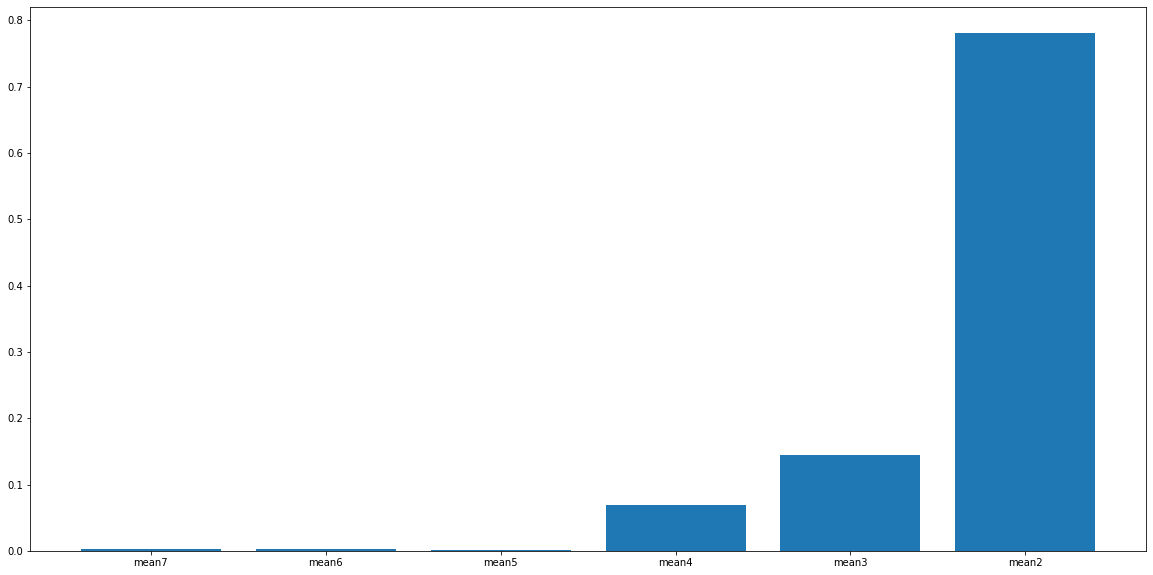

In [54]:
array = dataframe_mean.values
# split into input and output
X = array[:,0:-1]
y = array[:,-1]
# fit random forest model
model = RandomForestRegressor(n_estimators=500, random_state=1)
model.fit(X, y)
# show importance scores
print(model.feature_importances_)
# plot importance scores
names = dataframe_mean.columns.values[0:-1]
ticks = [i for i in range(len(names))]
pyplot.bar(ticks, model.feature_importances_)
pyplot.xticks(ticks, names)
pyplot.show()

Selected Features:
mean3
mean2


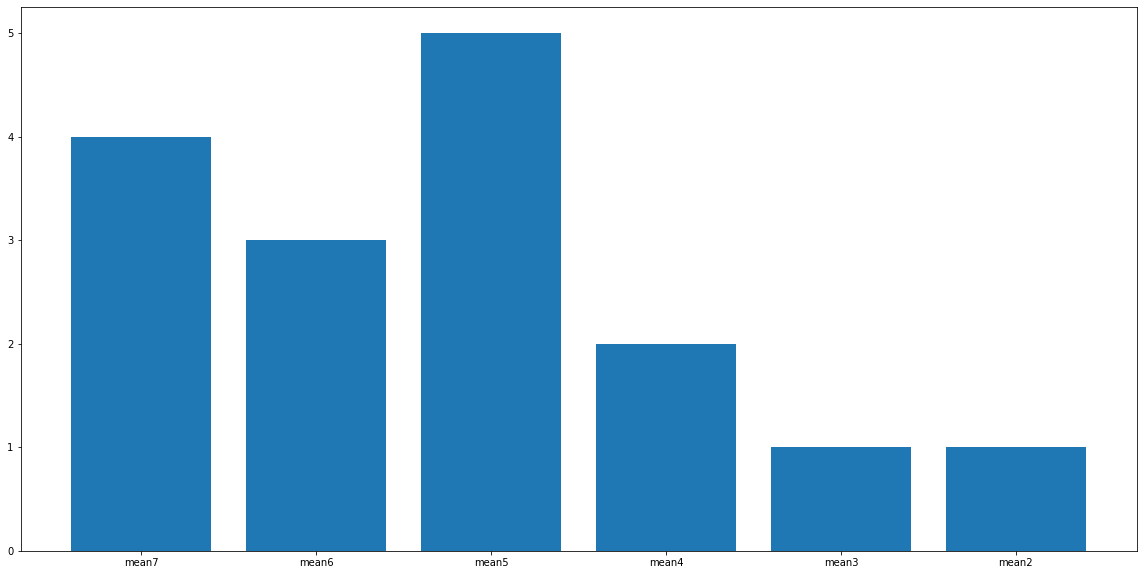

In [55]:
rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=1), n_features_to_select=2)
fit = rfe.fit(X, y)
# report selected features
print('Selected Features:')
names = dataframe_mean.columns.values[0:-1]
for i in range(len(fit.support_)):
    if fit.support_[i]:
        print(names[i])
# plot feature rank
names = dataframe_mean.columns.values[0:-1]
ticks = [i for i in range(len(names))]
pyplot.bar(ticks, fit.ranking_)
pyplot.xticks(ticks, names)
pyplot.show()

In [56]:
series["mean3"]=series["births"].rolling(window=3).mean()
series["mean2"]=series["births"].rolling(window=2).mean()


MAX

In [57]:
dataframe_max = DataFrame()
for i in range(7,1,-1):
	dataframe_max['max'+str(i)] = series.rolling(window=i).max().values[:,0]
dataframe_max['itself'] = series.values[:,0]
print(dataframe_max.head(8))

dataframe_max = dataframe_max[6:]

dataframe_max

      max7     max6     max5     max4     max3     max2   itself
0      NaN      NaN      NaN      NaN      NaN      NaN   8068.0
1      NaN      NaN      NaN      NaN      NaN  10850.0  10850.0
2      NaN      NaN      NaN      NaN  10850.0  10850.0   8328.0
3      NaN      NaN      NaN  10850.0  10850.0   8328.0   7065.0
4      NaN      NaN  11892.0  11892.0  11892.0  11892.0  11892.0
5      NaN  12425.0  12425.0  12425.0  12425.0  12425.0  12425.0
6  12425.0  12425.0  12425.0  12425.0  12425.0  12425.0  12141.0
7  12425.0  12425.0  12425.0  12425.0  12425.0  12141.0  12094.0


,max7,max6,max5,max4,max3,max2,itself
6,12425.0,12425.0,12425.0,12425.0,12425.0,12425.0,12141.0
7,12425.0,12425.0,12425.0,12425.0,12425.0,12141.0,12094.0
8,12425.0,12425.0,12425.0,12425.0,12141.0,12094.0,11868.0
9,12425.0,12425.0,12425.0,12141.0,12094.0,11868.0,8014.0
10,12425.0,12425.0,12141.0,12094.0,11868.0,8014.0,7172.0
...,...,...,...,...,...,...,...
360,13131.0,13131.0,11595.0,8714.0,7518.0,7518.0,7518.0
361,13131.0,13100.0,13100.0,13100.0,13100.0,13100.0,13100.0
362,13458.0,13458.0,13458.0,13458.0,13458.0,13458.0,13458.0
363,13458.0,13458.0,13458.0,13458.0,13458.0,13458.0,13100.0


[0.01994519 0.02375496 0.05579344 0.07478443 0.08649003 0.73923196]


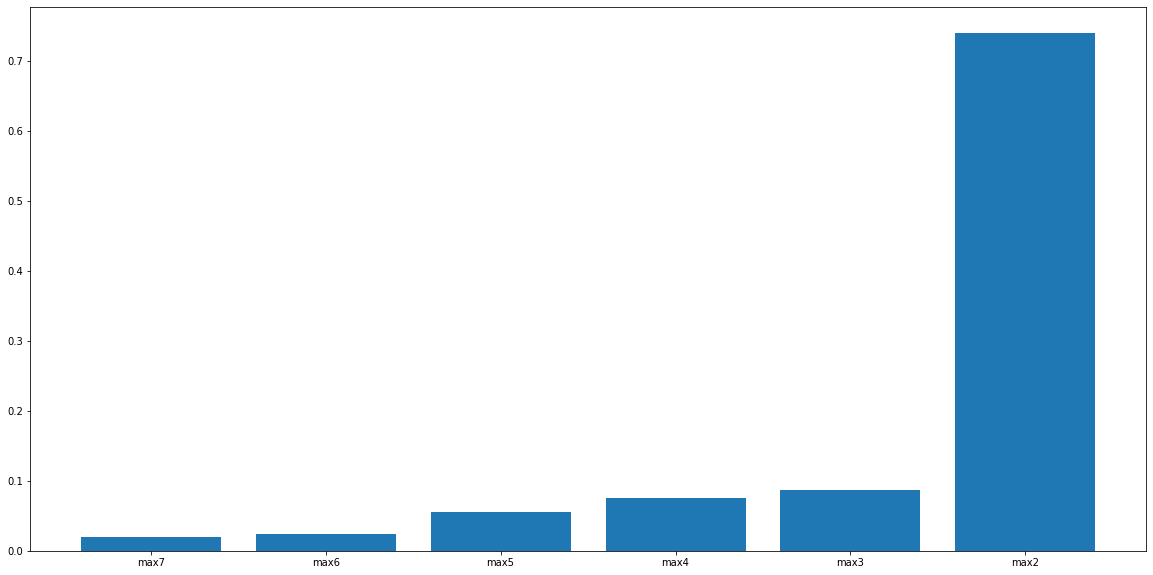

In [58]:
array = dataframe_max.values
# split into input and output
X = array[:,0:-1]
y = array[:,-1]
# fit random forest model
model = RandomForestRegressor(n_estimators=500, random_state=1)
model.fit(X, y)
# show importance scores
print(model.feature_importances_)
# plot importance scores
names = dataframe_max.columns.values[0:-1]
ticks = [i for i in range(len(names))]
pyplot.bar(ticks, model.feature_importances_)
pyplot.xticks(ticks, names)
pyplot.show()

Selected Features:
max3
max2


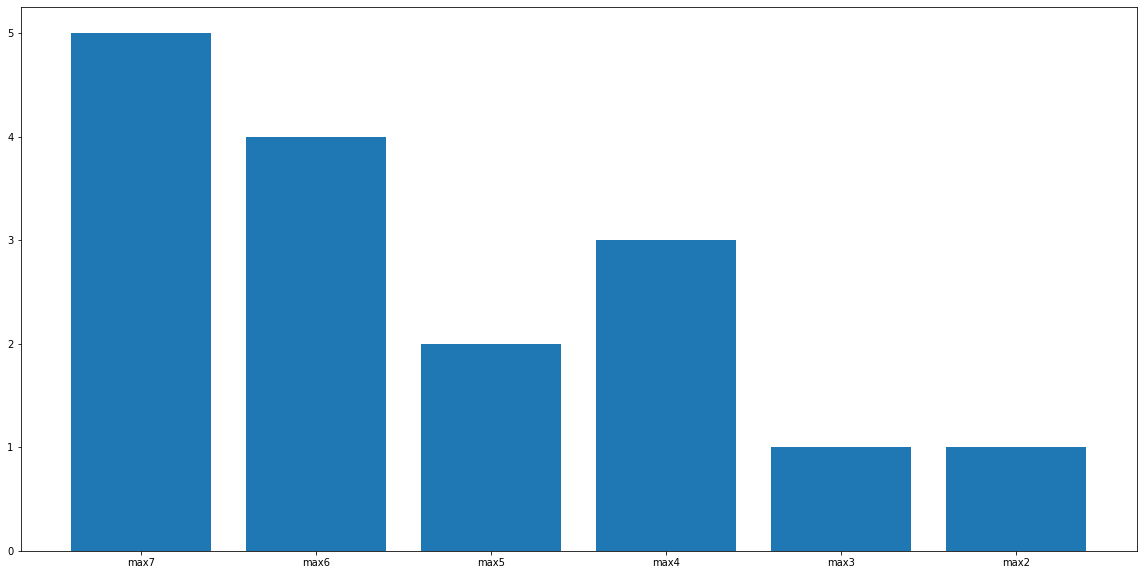

In [59]:

rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=1), n_features_to_select=2)
fit = rfe.fit(X, y)
# report selected features
print('Selected Features:')
names = dataframe_max.columns.values[0:-1]
for i in range(len(fit.support_)):
    if fit.support_[i]:
        print(names[i])
# plot feature rank
names = dataframe_max.columns.values[0:-1]
ticks = [i for i in range(len(names))]
pyplot.bar(ticks, fit.ranking_)
pyplot.xticks(ticks, names)
pyplot.show()

In [60]:
series["max3"]=series["births"].rolling(window=3).max()
series["max2"]=series["births"].rolling(window=2).max()


MIN

In [61]:
dataframe_min = DataFrame()
for i in range(7,1,-1):
	dataframe_min['min'+str(i)] = series.rolling(window=i).min().values[:,0]
dataframe_min['itself'] = series.values[:,0]
print(dataframe_min.head(8))

dataframe_min = dataframe_min[6:]

dataframe_min

     min7    min6    min5     min4     min3     min2   itself
0     NaN     NaN     NaN      NaN      NaN      NaN   8068.0
1     NaN     NaN     NaN      NaN      NaN   8068.0  10850.0
2     NaN     NaN     NaN      NaN   8068.0   8328.0   8328.0
3     NaN     NaN     NaN   7065.0   7065.0   7065.0   7065.0
4     NaN     NaN  7065.0   7065.0   7065.0   7065.0  11892.0
5     NaN  7065.0  7065.0   7065.0   7065.0  11892.0  12425.0
6  7065.0  7065.0  7065.0   7065.0  11892.0  12141.0  12141.0
7  7065.0  7065.0  7065.0  11892.0  12094.0  12094.0  12094.0


,min7,min6,min5,min4,min3,min2,itself
6,7065.0,7065.0,7065.0,7065.0,11892.0,12141.0,12141.0
7,7065.0,7065.0,7065.0,11892.0,12094.0,12094.0,12094.0
8,7065.0,7065.0,11868.0,11868.0,11868.0,11868.0,11868.0
9,7065.0,8014.0,8014.0,8014.0,8014.0,8014.0,8014.0
10,7172.0,7172.0,7172.0,7172.0,7172.0,7172.0,7172.0
...,...,...,...,...,...,...,...
360,6515.0,6515.0,6515.0,6515.0,6515.0,7294.0,7518.0
361,6515.0,6515.0,6515.0,6515.0,7294.0,7518.0,13100.0
362,6515.0,6515.0,6515.0,7294.0,7518.0,13100.0,13458.0
363,6515.0,6515.0,7294.0,7518.0,13100.0,13100.0,13100.0


[0.04913771 0.0505297  0.03276389 0.03445017 0.04993373 0.7831848 ]


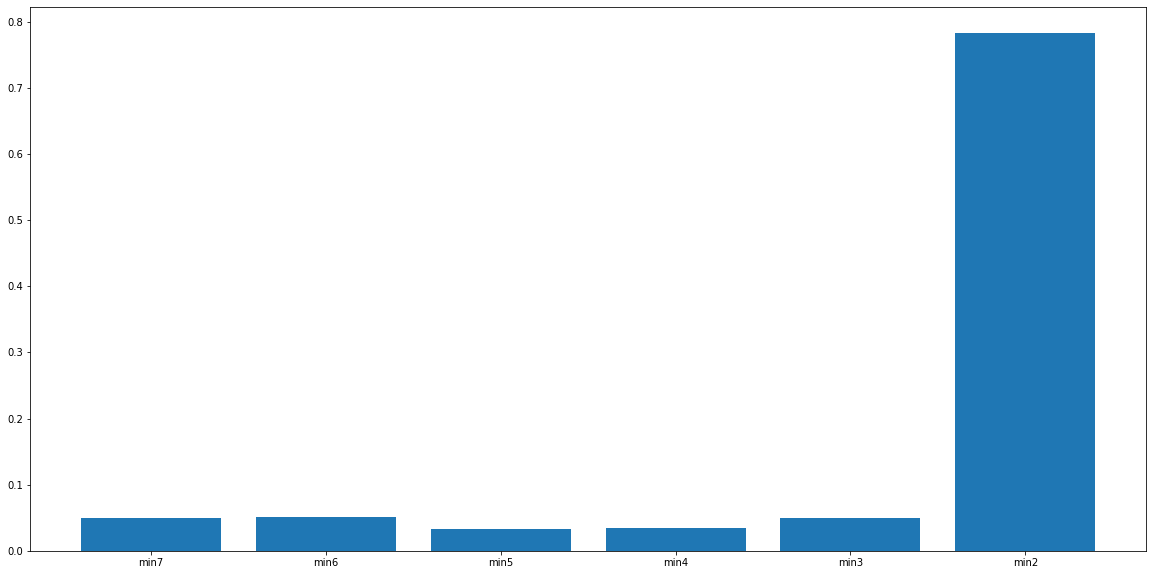

In [62]:
array = dataframe_min.values
# split into input and output
X = array[:,0:-1]
y = array[:,-1]
# fit random forest model
model = RandomForestRegressor(n_estimators=500, random_state=1)
model.fit(X, y)
# show importance scores
print(model.feature_importances_)
# plot importance scores
names = dataframe_min.columns.values[0:-1]
ticks = [i for i in range(len(names))]
pyplot.bar(ticks, model.feature_importances_)
pyplot.xticks(ticks, names)
pyplot.show()

Selected Features:
min3
min2


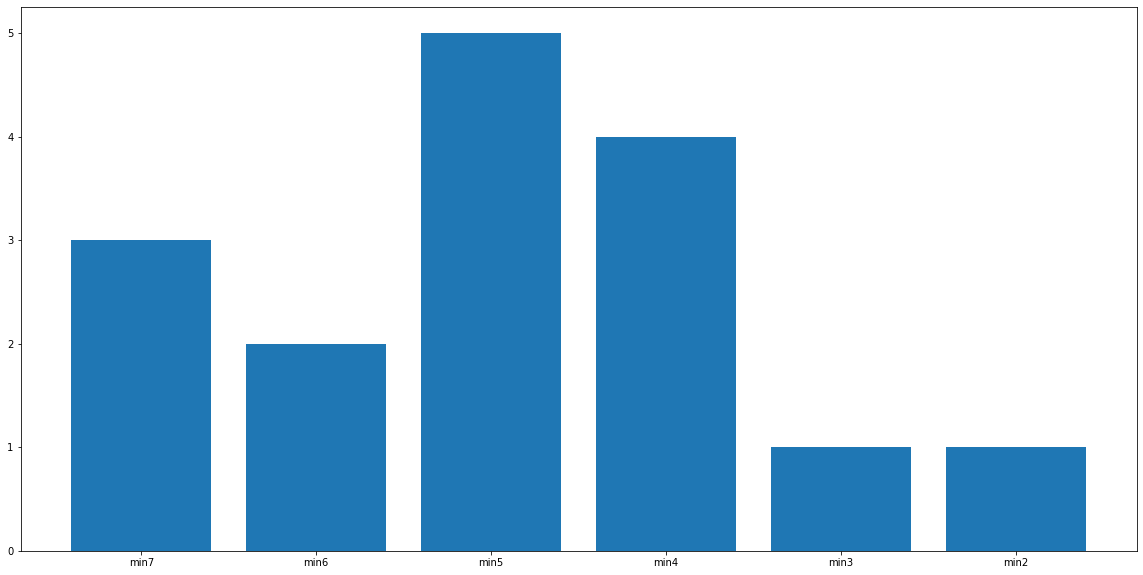

In [63]:

rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=1), n_features_to_select=2)
fit = rfe.fit(X, y)
# report selected features
print('Selected Features:')
names = dataframe_min.columns.values[0:-1]
for i in range(len(fit.support_)):
    if fit.support_[i]:
        print(names[i])
# plot feature rank
names = dataframe_min.columns.values[0:-1]
ticks = [i for i in range(len(names))]
pyplot.bar(ticks, fit.ranking_)
pyplot.xticks(ticks, names)
pyplot.show()


In [64]:
series["min3"]=series["births"].rolling(window=3).min()
series["min2"]=series["births"].rolling(window=2).min()


STD

In [65]:
dataframe_std = DataFrame()
for i in range(7,1,-1):
	dataframe_std['std'+str(i)] = series.rolling(window=i).min().values[:,0]
dataframe_std['itself'] = series.values[:,0]
print(dataframe_std.head(8))

dataframe_std = dataframe_std[6:]

dataframe_std

     std7    std6    std5     std4     std3     std2   itself
0     NaN     NaN     NaN      NaN      NaN      NaN   8068.0
1     NaN     NaN     NaN      NaN      NaN   8068.0  10850.0
2     NaN     NaN     NaN      NaN   8068.0   8328.0   8328.0
3     NaN     NaN     NaN   7065.0   7065.0   7065.0   7065.0
4     NaN     NaN  7065.0   7065.0   7065.0   7065.0  11892.0
5     NaN  7065.0  7065.0   7065.0   7065.0  11892.0  12425.0
6  7065.0  7065.0  7065.0   7065.0  11892.0  12141.0  12141.0
7  7065.0  7065.0  7065.0  11892.0  12094.0  12094.0  12094.0


,std7,std6,std5,std4,std3,std2,itself
6,7065.0,7065.0,7065.0,7065.0,11892.0,12141.0,12141.0
7,7065.0,7065.0,7065.0,11892.0,12094.0,12094.0,12094.0
8,7065.0,7065.0,11868.0,11868.0,11868.0,11868.0,11868.0
9,7065.0,8014.0,8014.0,8014.0,8014.0,8014.0,8014.0
10,7172.0,7172.0,7172.0,7172.0,7172.0,7172.0,7172.0
...,...,...,...,...,...,...,...
360,6515.0,6515.0,6515.0,6515.0,6515.0,7294.0,7518.0
361,6515.0,6515.0,6515.0,6515.0,7294.0,7518.0,13100.0
362,6515.0,6515.0,6515.0,7294.0,7518.0,13100.0,13458.0
363,6515.0,6515.0,7294.0,7518.0,13100.0,13100.0,13100.0


[0.04913771 0.0505297  0.03276389 0.03445017 0.04993373 0.7831848 ]


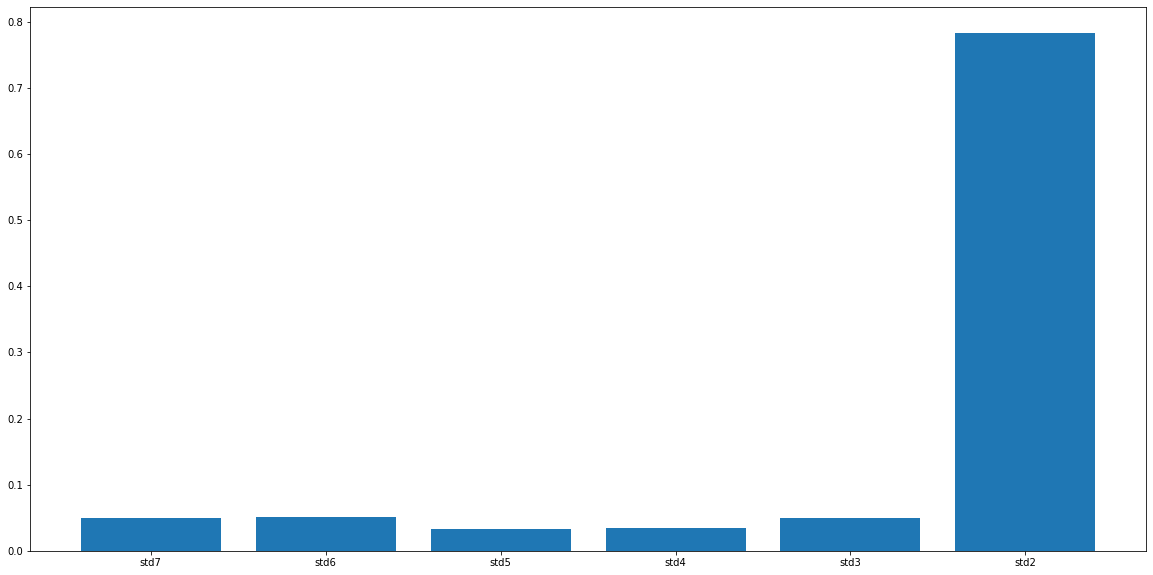

In [66]:
array = dataframe_std.values
# split into input and output
X = array[:,0:-1]
y = array[:,-1]
# fit random forest model
model = RandomForestRegressor(n_estimators=500, random_state=1)
model.fit(X, y)
# show importance scores
print(model.feature_importances_)
# plot importance scores
names = dataframe_std.columns.values[0:-1]
ticks = [i for i in range(len(names))]
pyplot.bar(ticks, model.feature_importances_)
pyplot.xticks(ticks, names)
pyplot.show()

Selected Features:
std3
std2


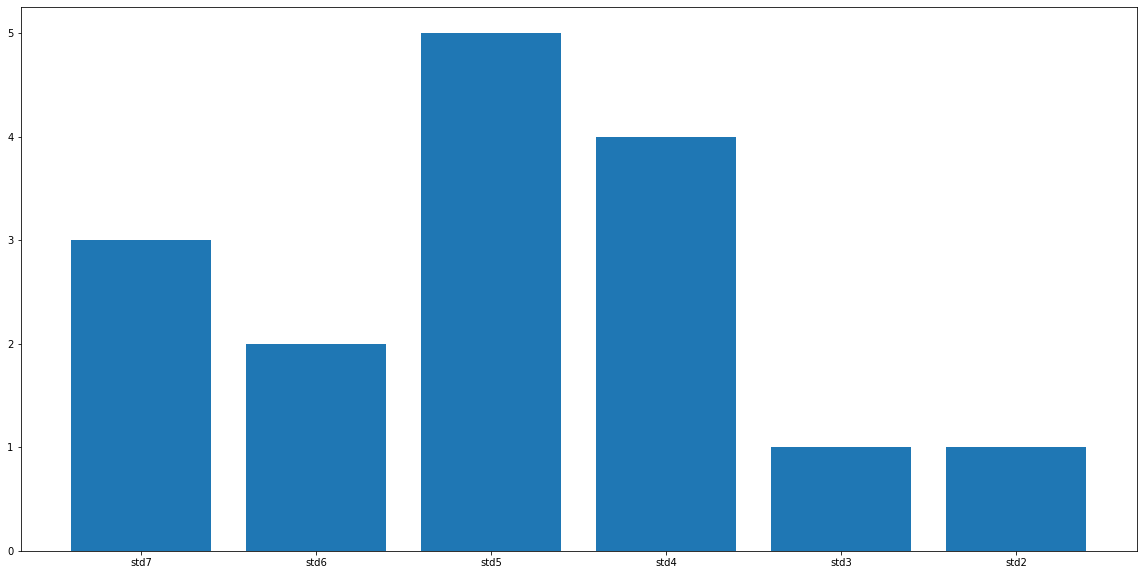

In [67]:

rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=1), n_features_to_select=2)
fit = rfe.fit(X, y)
# report selected features
print('Selected Features:')
names = dataframe_std.columns.values[0:-1]
for i in range(len(fit.support_)):
    if fit.support_[i]:
        print(names[i])
# plot feature rank
names = dataframe_std.columns.values[0:-1]
ticks = [i for i in range(len(names))]
pyplot.bar(ticks, fit.ranking_)
pyplot.xticks(ticks, names)
pyplot.show()

In [68]:
series["std3"]=series["births"].rolling(window=3).std()
series["std2"]=series["births"].rolling(window=2).std()


In [69]:
corrMatrix = series.corr()
corrMatrix

,births,lag7,lag5,mean3,mean2,max3,max2,min3,min2,std3,std2
births,1.000000,0.912860,-0.317490,0.548636,0.836185,0.426215,0.804710,0.489762,0.741663,-0.372198,-0.251435
lag7,0.912860,1.000000,-0.315560,0.483609,0.763813,0.317249,0.724165,0.441301,0.684631,-0.361970,-0.248381
lag5,-0.317490,-0.315560,1.000000,-0.602464,-0.455312,-0.185069,-0.303272,-0.678339,-0.496915,0.665399,0.388636
mean3,0.548636,0.483609,-0.602464,1.000000,0.866030,0.654930,0.693980,0.903580,0.864366,-0.727199,-0.520164
mean2,0.836185,0.763813,-0.455312,0.866030,1.000000,0.604619,0.879282,0.701222,0.944341,-0.523137,-0.455932
max3,0.426215,0.317249,-0.185069,0.654930,0.604619,1.000000,0.602849,0.389196,0.521656,-0.051012,-0.141933
max2,0.804710,0.724165,-0.303272,0.693980,0.879282,0.602849,1.000000,0.487284,0.673653,-0.288947,0.023023
min3,0.489762,0.441301,-0.678339,0.903580,0.701222,0.389196,0.487284,1.000000,0.751460,-0.938542,-0.560680
min2,0.741663,0.684631,-0.496915,0.864366,0.944341,0.521656,0.673653,0.751460,1.000000,-0.612169,-0.723342
std3,-0.372198,-0.361970,0.665399,-0.727199,-0.523137,-0.051012,-0.288947,-0.938542,-0.612169,1.000000,0.557705


Creating a heatmap using Seaborn on the top of the correlation matrix obtained above to visualize the correlation between the different numerical columns of the data. This is done when we have a large number of variables.

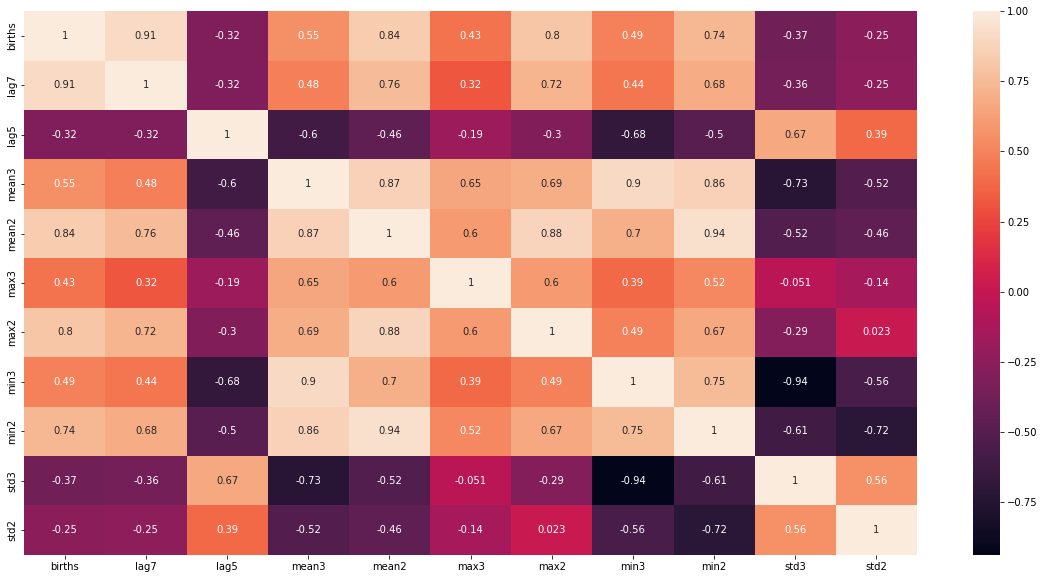

In [70]:
sns.heatmap(corrMatrix, annot= True)
plt.show()

log, lag7, max2, mean2, lag7 are highly correlated with births

In [77]:
features= pd.concat([series['lag7'],series["min2"],series["max2"]], axis=1)


In [78]:
series = series.dropna()

In [87]:
features[:335].shape

(335, 3)

In [84]:
train.shape

(335, 1)

In [88]:

# SARIMAX Model

SARIMAX_model = pm.auto_arima(train["births"], exogenous= features[:335],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)


In [89]:
TEST_SIZE = 30
train, test = series.iloc[:-TEST_SIZE], series.iloc[-TEST_SIZE:]
x_train, x_test = np.array(range(train.shape[0])), np.array(range(train.shape[0], data.shape[0]))
train.shape, x_train.shape, test.shape, x_test.shape

((328, 11), (328,), (30, 11), (37,))

In [90]:
len(features[328:])

30

In [91]:
# Forecast

SARIMAX_model_fit= SARIMAX_model.fit(train["births"],exogenous= features[:328] )

prediction, confint = SARIMAX_model_fit.predict(n_periods=30, return_conf_int=True,exogenous=  features[328:])

prediction

array([12130.65319058,  8627.90807886,  9761.26219015,  8511.92489301,
        7145.94686801, 11668.00397908, 12715.82968442, 12409.80279425,
       12434.24660958, 11866.18177364,  8582.13873095,  7076.76383908,
       11190.29964537, 12214.51681328, 11993.59259071, 12328.99991451,
       11625.9083892 ,  8865.53407252,  7044.65563246, 11396.02903645,
       12825.67202747, 12421.71126816, 11698.06233577, 10898.9561062 ,
        7719.62069795,  7005.01085763, 12350.27783514, 13306.16325453,
       12100.87260706,  9821.07063901])

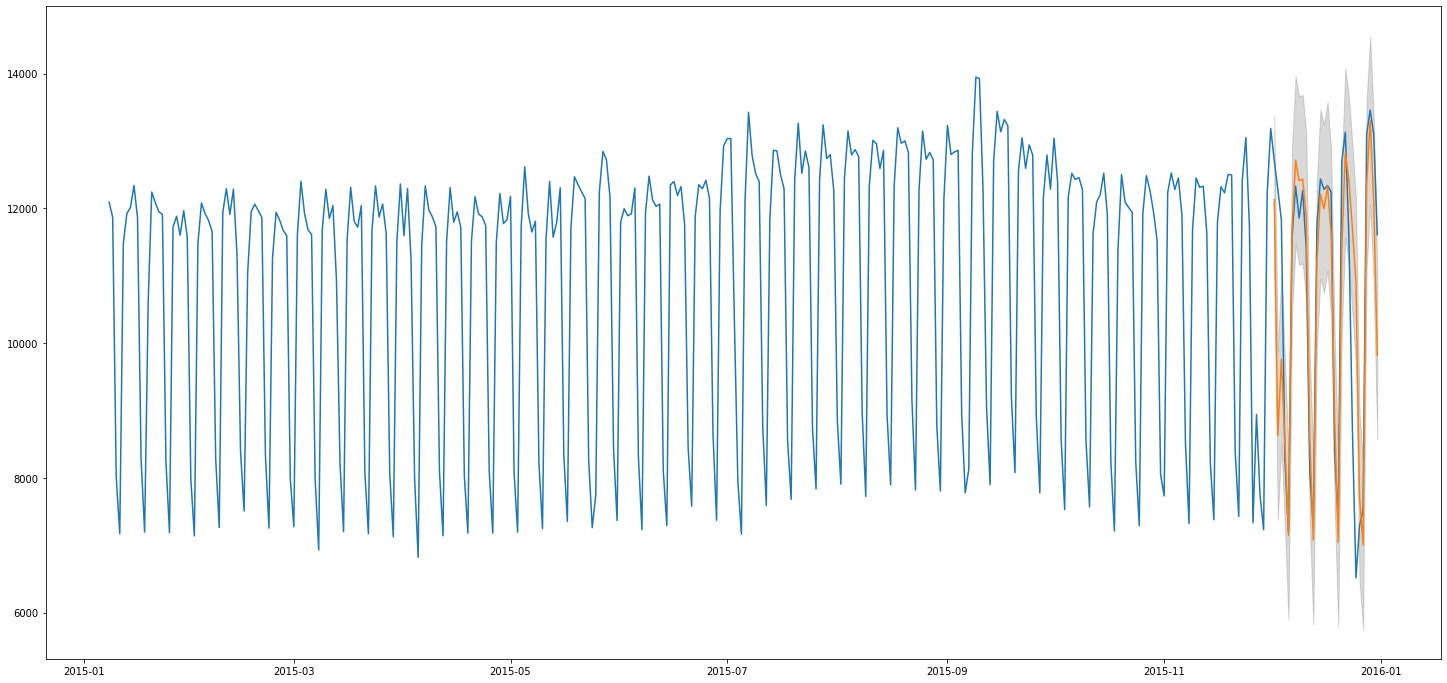

In [92]:

cf= pd.DataFrame(confint)


prediction_series = pd.Series(prediction,index=test.index)
fig, ax = plt.subplots(1, 1, figsize=(25, 12))
ax.plot(series.births)
ax.plot(prediction_series)
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)

In [93]:
MAPE(series["births"][328:],prediction)

8.883675571754459

%92 Accuracy